In [6]:
import pandas as pd
import numpy as np
from itertools import combinations
from functional import seq
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
from scipy.stats import percentileofscore
import mne
import dit 
from dit.multivariate import total_correlation,dual_total_correlation,coinformation
from tqdm import tqdm
from scipy.stats import skew
from brain_data_reader import load_subjet_data, only_useful_data, binarize_data
from sklearn.feature_selection import mutual_info_regression
from scipy.linalg import cholesky

def boolean_joint_distribution(*variables):
    def joint_symbols_to_string(symbols):
        return np.array2string(symbols,separator='')[1:-1]
    joint_symbols,frequencies = np.unique(list(zip(*variables)), axis=0, return_counts=True)
    symbol_strings            = list(map(joint_symbols_to_string,joint_symbols))
    distribution              = dit.Distribution(symbol_strings, frequencies/sum(frequencies))
    return distribution

def read_pid_table(pid_table):
    pid_dict = {}
    pid_rows = pid_table.split('\n')[3:-1]
    for row in pid_rows:
        contents = row.split('|')
        pid_dict[contents[1].strip()] = float(contents[3])
    return pid_dict

def validate_channel(chanel_id: str) -> bool:
    return chanel_id.startswith('EEG') and not ('z' in chanel_id or 'A' in chanel_id)

def cholesky_surrogates(series):
    s = np.copy(series)

    for i in range(len(s)):
        s[i] = np.random.permutation(s[i])
        s[i] = (s[i]-np.mean(s[i]))/np.std(s[i])
    pearson_corr  = np.corrcoef(series)
    x             = s
    c             = cholesky(pearson_corr, lower=True)
    choles        = np.dot(c, x)
    return choles

def Oinfo(*rvs):
    dist = boolean_joint_distribution(*rvs)
    O    = total_correlation(dist)-dual_total_correlation(dist)
    return O

def total_corr(*rvs):
    dist = boolean_joint_distribution(*rvs)
    tc    = total_correlation(dist)
    return tc

def dual_total_corr(*rvs):
    dist = boolean_joint_distribution(*rvs)
    dtc    = dual_total_correlation(dist)
    return dtc

def symbolize(series,pctls):
    boundaries      = [np.percentile(series,q) for q in pctls]
    symbolic_series = np.digitize(series,boundaries)
    return symbolic_series

<font size = 10> <center>__BEFORE__ ARITHMETIC TASK

In [2]:
raw = mne.io.read_raw_edf(r"C:\Users\rober\NeuNet\ArithmeticTasks\data\Subject31_1.edf")
# raw = mne.io.read_raw_edf("Subject32_1.edf")

Extracting EDF parameters from C:\Users\rober\NeuNet\ArithmeticTasks\data\Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
#raw to DataFrame
data_df      = raw.to_data_frame()
all_channels = data_df.columns.to_numpy()

# only 1min of data (if rest)
data_df = data_df[(0<=data_df.time) & (data_df.time<=60)]

# keep only useful channels
data_df = data_df.drop(columns=['ECG ECG','EEG A2-A1'])

#re-referenced data
data_df_reref = data_df.sub(data_df.mean(axis=1), axis=0)

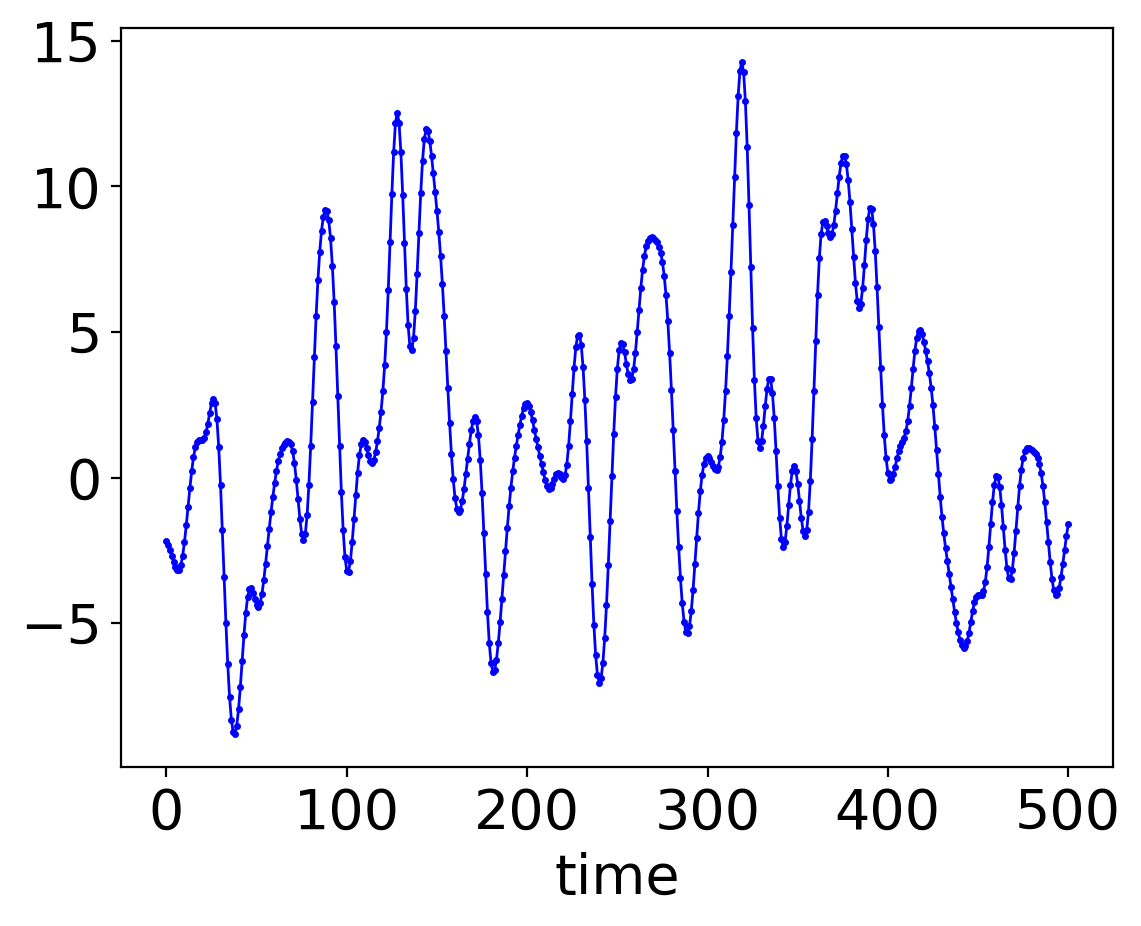

In [4]:
data_df['EEG F7'][data_df.time<=1].plot(lw=1,marker='.',markersize=3,c='blue')
plt.xlabel('time',size=20)
plt.xticks(size=20);
plt.yticks(size=20);

In [8]:
raw_125 = raw.copy().resample(sfreq=125)

In [9]:
#raw to DataFrame
data_df_125      = raw_125.to_data_frame()
all_channels_125 = data_df_125.columns.to_numpy()

# only 1min of data (if rest)
data_df_125 = data_df_125[(0<=data_df_125.time) & (data_df_125.time<=60)]

# keep only useful channels
data_df_125 = data_df_125.drop(columns=['ECG ECG','EEG A2-A1'])

In [10]:
data_df.index = data_df.time
data_df_125.index = data_df_125.time

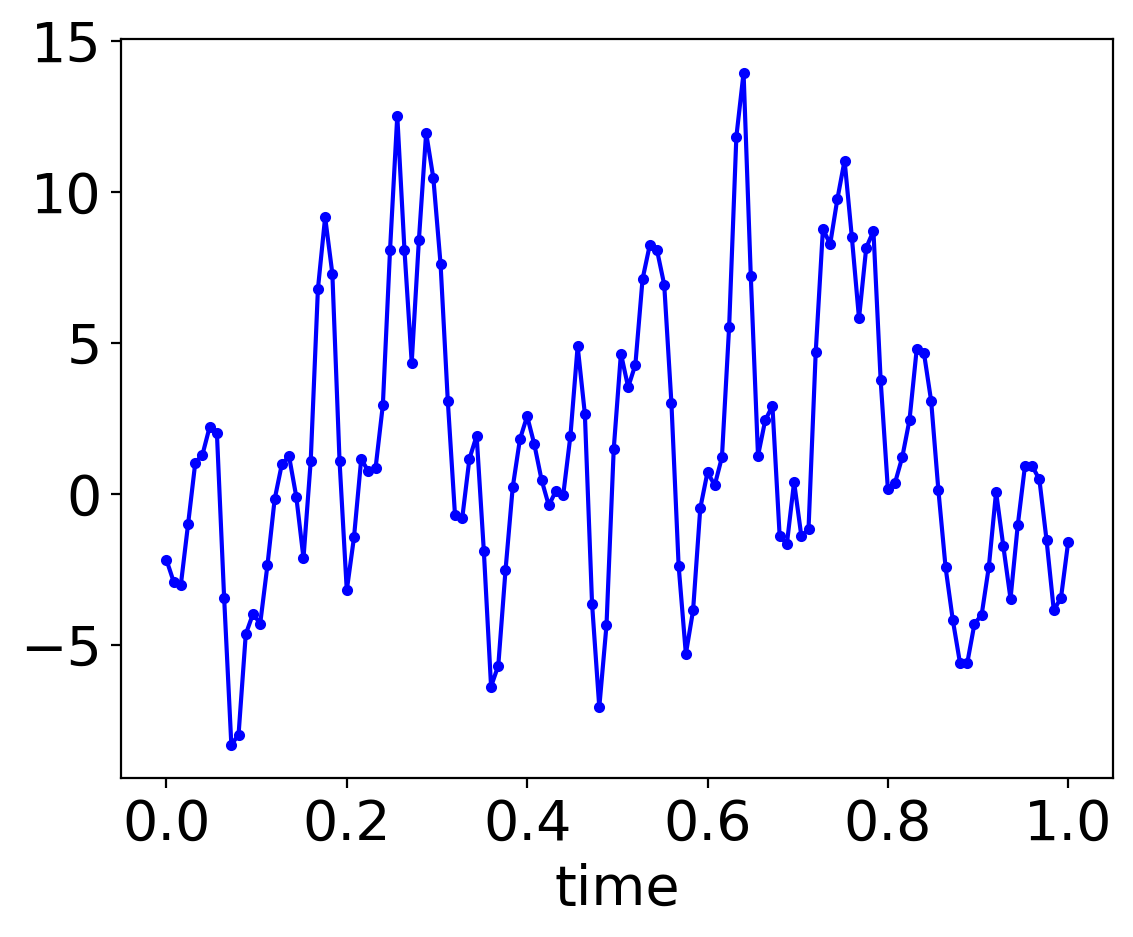

In [11]:
data_df_125['EEG F7'][data_df_125.time<=1].plot(color='blue',marker='.')
plt.xlabel('time',size=20)
plt.xticks(size=20);
plt.yticks(size=20);

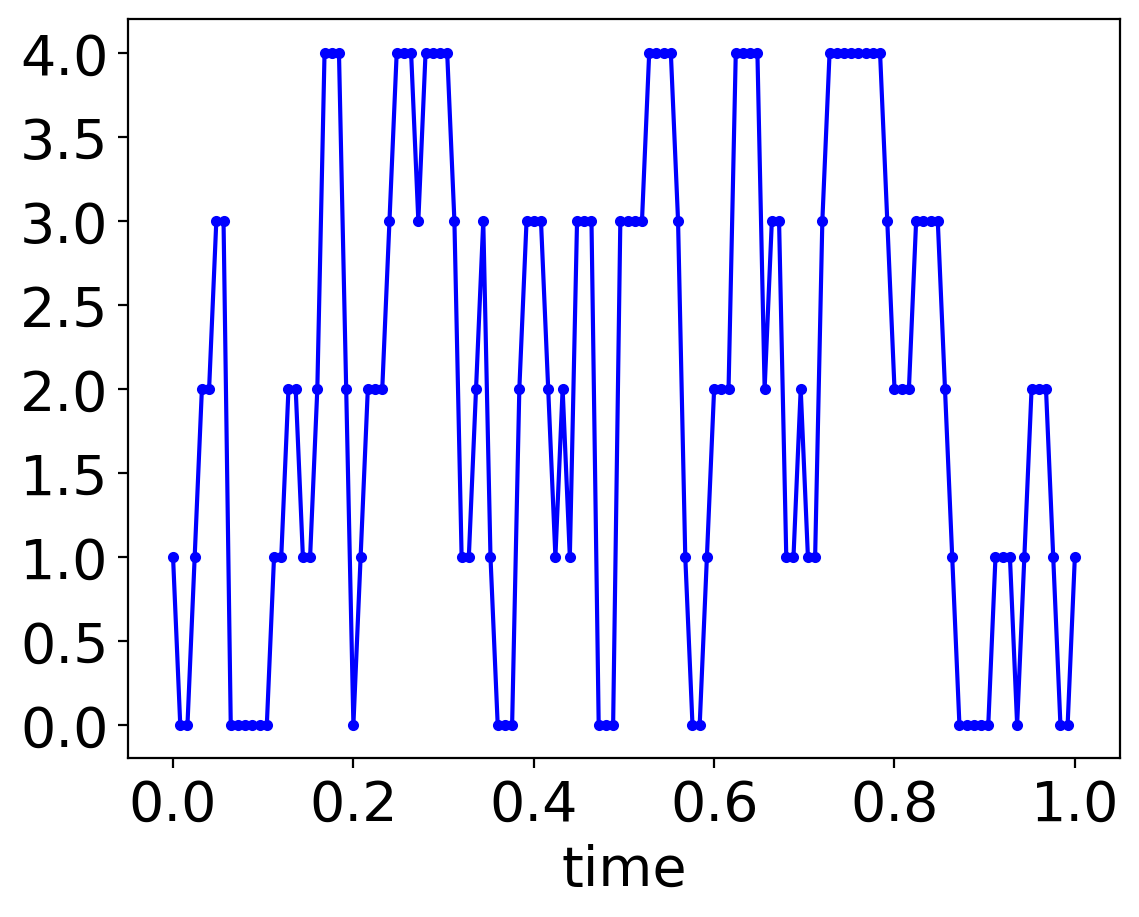

In [12]:
plt.plot(symbolize(data_df_125['EEG F7'][data_df_125.time<=1].to_numpy(),[20,40,60,80]),
         c='blue',marker='.')
plt.xticks(range(0,150,25),np.round(np.linspace(0,1,6),2));
plt.xlabel('time',size=20)
plt.xticks(size=20);
plt.yticks(size=20);

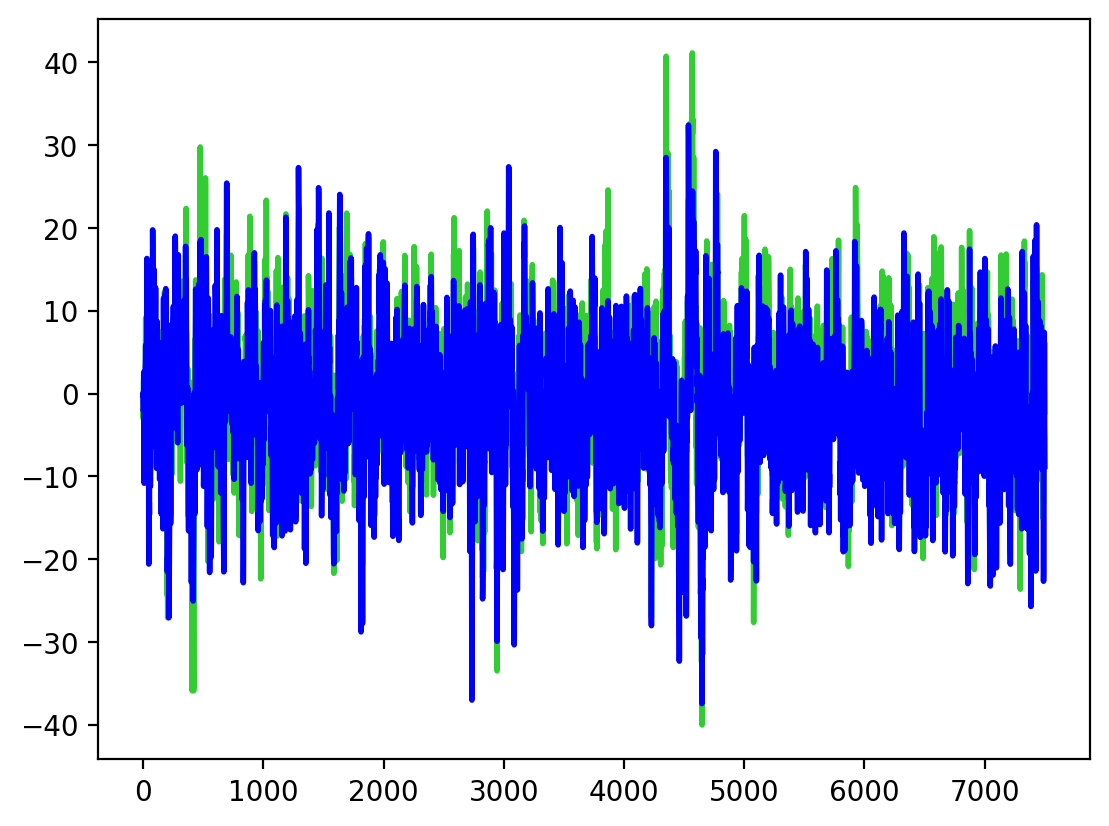

In [24]:
plt.plot(data_df['EEG F7'][:],c='limegreen',lw=2)
plt.plot(data_df_reref['EEG F7'][:],c='blue',lw=2)

In [20]:
data_df['EEG F4'][:5]

time
0.000    -0.464095
0.008    -0.855272
0.016    -1.821274
0.024    -2.168849
0.032    -3.239257
           ...    
4.968    -4.977782
4.976    -7.162782
4.984   -10.704181
4.992    -9.513546
5.000    -2.269188
Name: EEG F4, Length: 626, dtype: float64

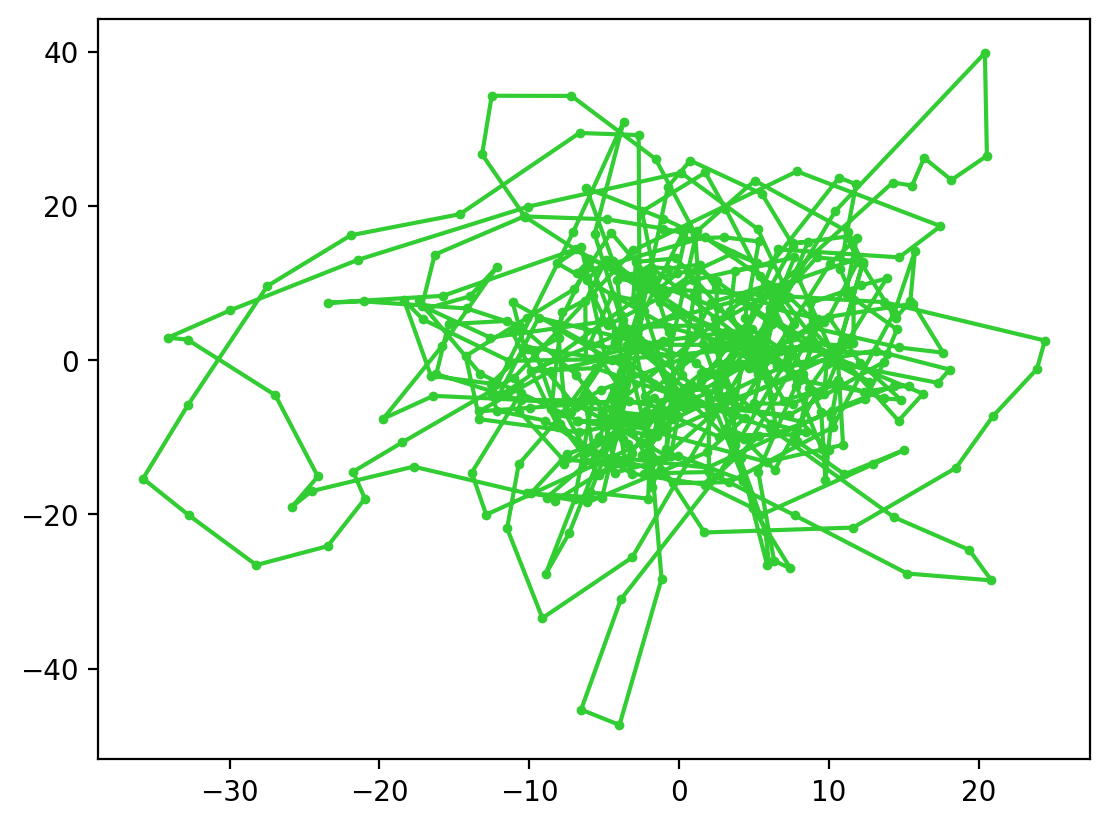

In [29]:
plt.plot(data_df['EEG F4'][:500],data_df['EEG O2'][:500],markersize=5,marker='.',alpha=1,c='limegreen',ls='-')
# plt.plot(data_df_reref['EEG F4'][:100],data_df_reref['EEG O2'][:100],markersize=2,marker='.',alpha=1,c='blue')

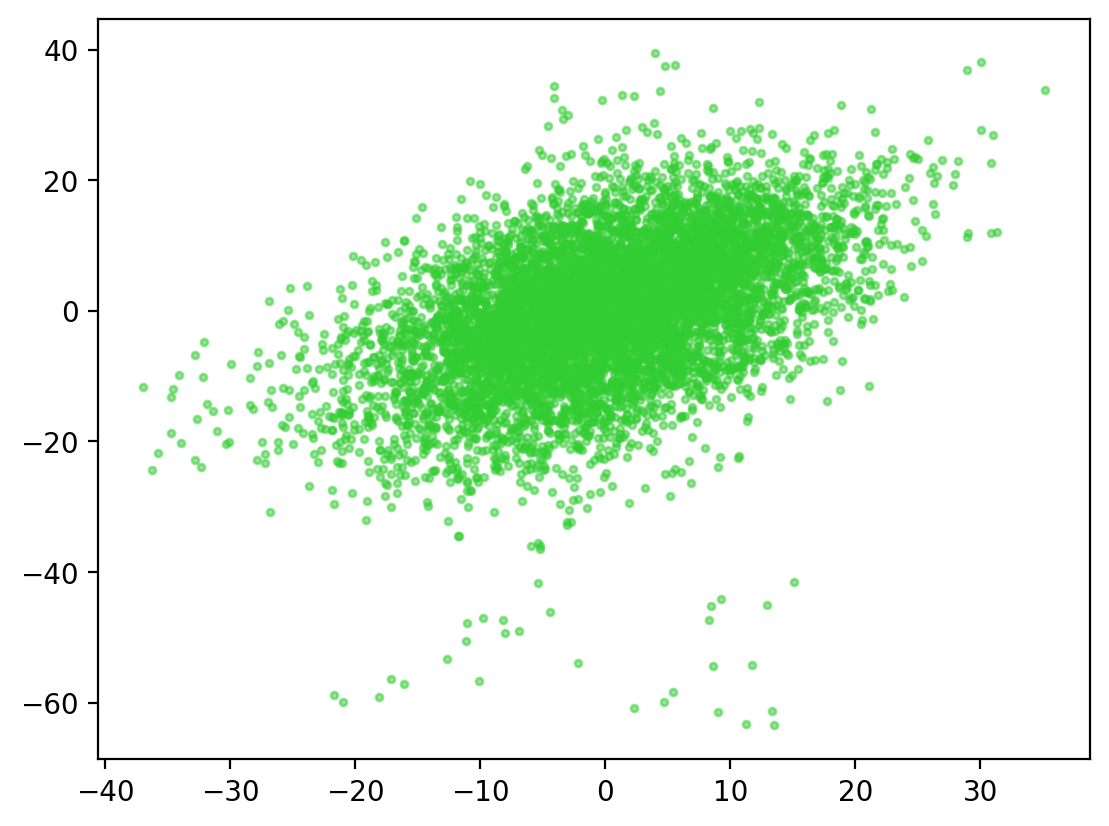

In [30]:
plt.plot(data_df['EEG F4'][:60*500],data_df['EEG F8'][:60*500],markersize=5,marker='.',alpha=0.5,
         c='limegreen',ls='')

In [26]:
valid_channels_mask = list(map(validate_channel,all_channels))
valid_channels      = all_channels[valid_channels_mask]
data_df             = data_df[valid_channels]

In [47]:
# subset3 = np.vstack((data_df['EEG F7'], data_df['EEG T3'], data_df['EEG C3']))
subset3 = np.vstack((data_df_reref['EEG F7'], data_df_reref['EEG T3'], data_df_reref['EEG C3']))

In [49]:
nullcho1, nullcho2, nullcho3 = [],[],[]

for _ in tqdm(list(range(100))):
    
    xcho, ycho, zcho    = cholesky_surrogates(subset3)

    b1cho = np.where(xcho>np.median(xcho),1,0)
    b2cho = np.where(ycho>np.median(ycho),1,0)
    b3cho = np.where(zcho>np.median(zcho),1,0)

    distro1cho = boolean_joint_distribution(b1cho,b2cho,b3cho)
    nullcho1.append(read_pid_table(dit.pid.PID_WB(distro1cho).to_string())['{0:1}'])

    distro2cho = boolean_joint_distribution(b1cho,b3cho,b2cho)
    nullcho2.append(read_pid_table(dit.pid.PID_WB(distro2cho).to_string())['{0:1}'])

    distro3cho = boolean_joint_distribution(b2cho,b3cho,b1cho)
    nullcho3.append(read_pid_table(dit.pid.PID_WB(distro3cho).to_string())['{0:1}'])  

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


In [50]:
b1 = np.where(subset3[0]>np.median(subset3[0]),1,0)
b2 = np.where(subset3[1]>np.median(subset3[1]),1,0)
b3 = np.where(subset3[2]>np.median(subset3[2]),1,0)

In [51]:
subset3_binary     = np.vstack((b1,b2,b3))

In [52]:
distro3_1 = boolean_joint_distribution(b1,b2,b3)
print("1,2 -> 3")
print(dit.pid.PID_WB(distro3_1))

distro3_2 = boolean_joint_distribution(b1,b3,b2)
print("1,3 -> 2")
print(dit.pid.PID_WB(distro3_2))

distro3_3 = boolean_joint_distribution(b2,b3,b1)
print("2,3 -> 1")
print(dit.pid.PID_WB(distro3_3))

1,2 -> 3
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.3271 | 0.0048 |
|  {0}   | 0.0524 | 0.0000 |
|  {1}   | 0.3222 | 0.2698 |
| {0}{1} | 0.0524 | 0.0524 |
+--------+--------+--------+
1,3 -> 2
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.3515 | 0.0293 |
|  {0}   | 0.0769 | 0.0000 |
|  {1}   | 0.3222 | 0.2453 |
| {0}{1} | 0.0769 | 0.0769 |
+--------+--------+--------+
2,3 -> 1
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.0817 | 0.0048 |
|  {0}   | 0.0769 | 0.0244 |
|  {1}   | 0.0524 | 0.0000 |
| {0}{1} | 0.0524 | 0.0524 |
+--------+--------+--------+


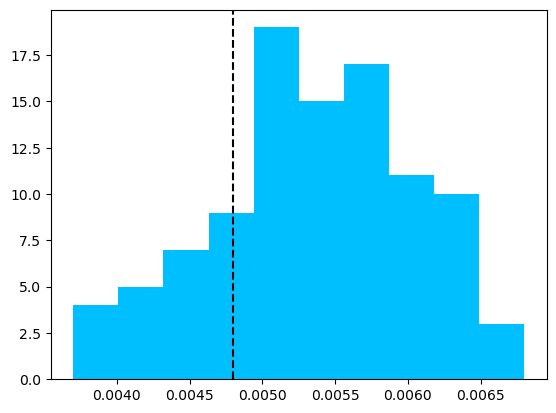

In [53]:
plt.hist(nullcho3,bins=10,color='deepskyblue')
plt.axvline(read_pid_table(dit.pid.PID_WB(distro3_3).to_string())['{0:1}'],ls='--',c='black')

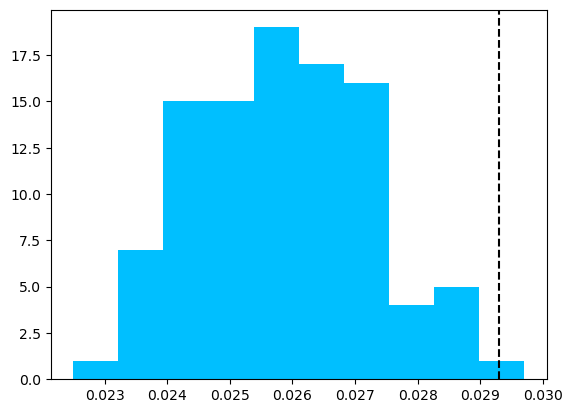

In [54]:
plt.hist(nullcho2,bins=10,color='deepskyblue')
plt.axvline(read_pid_table(dit.pid.PID_WB(distro3_2).to_string())['{0:1}'],ls='--',c='black')

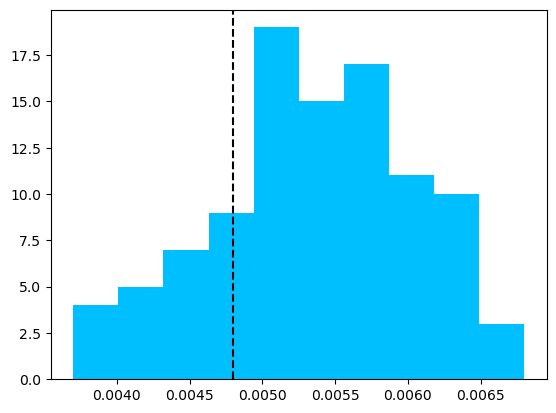

In [55]:
plt.hist(nullcho1,bins=10,color='deepskyblue')
plt.axvline(read_pid_table(dit.pid.PID_WB(distro3_1).to_string())['{0:1}'],ls='--',c='black')

In [56]:
nullrnd1, nullrnd2, nullrnd3 = [],[],[]

for _ in tqdm(list(range(100))):
    
    xrnd, yrnd, zrnd    = cholesky_surrogates(subset3)

    b1rnd = np.where(xrnd>np.median(xrnd),1,0)
    b2rnd = np.where(yrnd>np.median(yrnd),1,0)
    b3rnd = np.where(zrnd>np.median(zrnd),1,0)

    distro1rnd = boolean_joint_distribution(b1rnd,b2rnd,b3rnd)
    nullcho1.append(read_pid_table(dit.pid.PID_WB(distro1rnd).to_string())['{0:1}'])

    distro2rnd = boolean_joint_distribution(b1rnd,b3rnd,b2rnd)
    nullrnd2.append(read_pid_table(dit.pid.PID_WB(distro2rnd).to_string())['{0:1}'])

    distro3rnd = boolean_joint_distribution(b2rnd,b3rnd,b1rnd)
    nullrnd3.append(read_pid_table(dit.pid.PID_WB(distro3rnd).to_string())['{0:1}'])  

1,2 -> 3
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.3223 | 0.0000 |
|  {0}   | 0.0000 | 0.0000 |
|  {1}   | 0.3222 | 0.3221 |
| {0}{1} | 0.0000 | 0.0000 |
+--------+--------+--------+
1,3 -> 2
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.3222 | 0.0000 |
|  {0}   | 0.0000 | 0.0000 |
|  {1}   | 0.3222 | 0.3222 |
| {0}{1} | 0.0000 | 0.0000 |
+--------+--------+--------+
2,3 -> 1
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.0525 | 0.0000 |
|  {0}   | 0.0000 | 0.0000 |
|  {1}   | 0.0524 | 0.0524 |
| {0}{1} | 0.0000 | 0.0000 |
+--------+--------+--------+


In [88]:
read_pid_table(dit.pid.PID_WB(distro3_1).to_string())['{0:1}']

0.0267

In [19]:
with open("Output.txt", "w") as text_file:
    text_file.write(dit.pid.PID_WB(distro3_1).to_string())

In [20]:
with open("Output.txt", "r") as f: 
    dafile = f.read() 

In [41]:
permutation_id = 'EEG T5'+ ',' + 'EEG P3' + '-' + 'EEG O1'
with open(permutation_id+".txt", "w") as text_file:
    text_file.write(dit.pid.PID_WB(distro3_1).to_string())

<font size = 10> <center> __DURING__ ARITHMETIC TASK

In [62]:
raw = mne.io.read_raw_edf(r"C:\Users\rober\NeuNet\ArithmeticTasks\data\Subject30_2.edf")

Extracting EDF parameters from C:\Users\rober\NeuNet\ArithmeticTasks\data\Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [63]:
data_df = raw.to_data_frame()
# data_df = data_df[valid_channels]

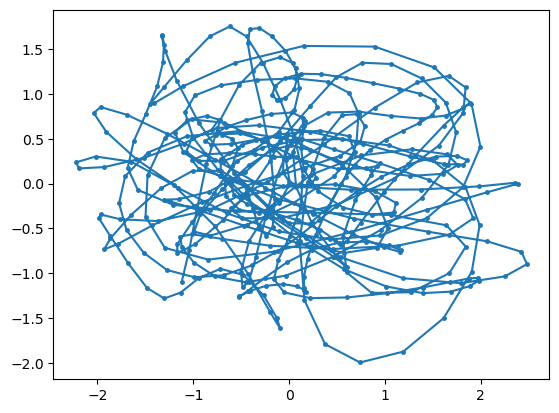

In [65]:
k = 1
N = 500
plt.plot(data_df['EEG F4'].diff()[(k-1)*N:k*N],data_df['EEG O2'].diff()[(k-1)*N:k*N],markersize=5,marker='.')

In [ ]:
k = 1
N = 500
plt.plot(data_df['EEG F4'][(k-1)*N:k*N],data_df['EEG O2'][(k-1)*N:k*N],markersize=5,marker='.')

In [51]:
subset3 = np.vstack((data_df['EEG T5'],
                     data_df['EEG P3'],
                     data_df['EEG O1']))

In [52]:
plt.plot(data_df['EEG O1'])

In [53]:
b1 = np.where(subset3[0]>np.median(subset3[0]),1,0)
b2 = np.where(subset3[1]>np.median(subset3[1]),1,0)
b3 = np.where(subset3[2]>np.median(subset3[2]),1,0)

In [54]:
subset3_binary = np.vstack((b1,b2,b3))

In [55]:
plt.pcolor(subset3_binary,cmap='binary')
plt.show()

In [56]:
distro3_1 = boolean_joint_distribution(b1,b2,b3)
print("1,2 -> 3")
print(dit.pid.PID_WB(distro3_1))

distro3_2 = boolean_joint_distribution(b1,b3,b2)
print("1,3 -> 2")
print(dit.pid.PID_WB(distro3_2))

distro3_3 = boolean_joint_distribution(b2,b3,b1)
print("2,3 -> 1")
print(dit.pid.PID_WB(distro3_3))

1,2 -> 3
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.2629 | 0.0177 |
|  {0}   | 0.1082 | 0.0000 |
|  {1}   | 0.2452 | 0.1369 |
| {0}{1} | 0.1082 | 0.1082 |
+--------+--------+--------+
1,3 -> 2
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.3190 | 0.0739 |
|  {0}   | 0.1644 | 0.0000 |
|  {1}   | 0.2452 | 0.0808 |
| {0}{1} | 0.1644 | 0.1644 |
+--------+--------+--------+
2,3 -> 1
+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.1821 | 0.0177 |
|  {0}   | 0.1644 | 0.0562 |
|  {1}   | 0.1082 | 0.0000 |
| {0}{1} | 0.1082 | 0.1082 |
+--------+--------+--------+


In [146]:
dit.multivariate.coinformation(distro3_2)

0.28404369169973176

# <font size=10><center> All test subjects - Only 1 electrode triad

In [77]:
subject_performances = pd.read_csv(r"C:\Users\rober\NeuNet\ArithmeticTasks\subject-info.csv")

### Triad: Fp1, F3, F7

<img src="21_electrodes_of_International_10-20_system_for_EEG.png" width=360 height=360 />

In [61]:
T1,T2,T3 = 'EEG Fp1','EEG F3','EEG F7'

### <center>At Rest

In [168]:
rest_pids = {"Subject"+str(i):{} for i in range(36)}
rest_coinformations = []
for i in tqdm(list(range(36))):
    # --------------------------------------------------------------------------------------------read data
    raw     = mne.io.read_raw_edf(r"C:\Users\rober\NeuNet\ArithmeticTasks\Subject"+str(i)+"_1.edf",verbose=False);
    data_df = raw.to_data_frame()
    # --------------------------------------------------------------------------------------------choose 3 electrodes
    Electrode1 = data_df[T1]
    Electrode2 = data_df[T2]
    Electrode3 = data_df[T3]
    # --------------------------------------------------------------------------------------------binarize electrode signals
    binary1 = np.where(Electrode1>np.percentile(Electrode1,50),1,0)
    binary2 = np.where(Electrode2>np.percentile(Electrode2,50),1,0)
    binary3 = np.where(Electrode3>np.percentile(Electrode3,50),1,0)
    # --------------------------------------------------------------------------------------------compute PID for all 3 permutations of the electrodes
    distro3_1 = boolean_joint_distribution(binary1,binary2,binary3)
    pid3_1    = dit.pid.PID_WB(distro3_1).to_string()
    distro3_2 = boolean_joint_distribution(binary1,binary3,binary2)
    pid3_2    = dit.pid.PID_WB(distro3_2).to_string()
    distro3_3 = boolean_joint_distribution(binary2,binary3,binary1)
    pid3_3    = dit.pid.PID_WB(distro3_3).to_string()
    # --------------------------------------------------------------------------------------------store PID results
    # rest_pids["Subject"+str(i)]['perm1'] = read_pid_table(pid3_1)['{0:1}']
    # rest_pids["Subject"+str(i)]['perm2'] = read_pid_table(pid3_2)['{0:1}']
    # rest_pids["Subject"+str(i)]['perm3'] = read_pid_table(pid3_3)['{0:1}']
    rest_coinformations.append(dit.multivariate.coinformation(distro3_1))

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:26<00:00,  1.38it/s]


(array([ 6.,  6., 10.,  7.,  2.,  1.,  2.,  0.,  1.,  1.]),
 array([0.00270414, 0.0452624 , 0.08782067, 0.13037893, 0.17293719,
        0.21549546, 0.25805372, 0.30061199, 0.34317025, 0.38572851,
        0.42828678]),
 <BarContainer object of 10 artists>)

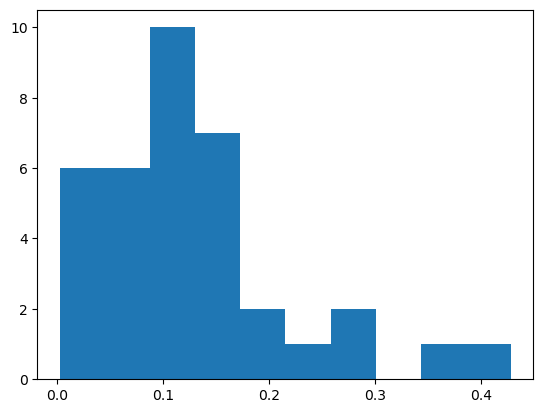

In [169]:
plt.hist(rest_coinformations)

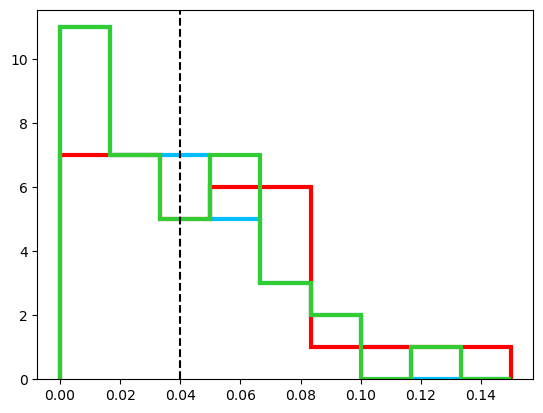

In [73]:
plt.hist([rest_pids["Subject"+str(i)]['perm1'] for i in range(36)],histtype='step',linewidth=3,color='deepskyblue',bins=np.linspace(0,0.15,10))
plt.hist([rest_pids["Subject"+str(i)]['perm2'] for i in range(36)],histtype='step',linewidth=3,color='red',bins=np.linspace(0,0.15,10))
plt.hist([rest_pids["Subject"+str(i)]['perm3'] for i in range(36)],histtype='step',linewidth=3,color='limegreen',bins=np.linspace(0,0.15,10))
plt.axvline(0.04,c='black',ls='--')
plt.show()

In [144]:
# plt.scatter(subject_performances['Number of subtractions'],[rest_pids["Subject"+str(i)]['perm1'] for i in range(36)])
# plt.scatter(subject_performances['Number of subtractions'],[rest_pids["Subject"+str(i)]['perm2'] for i in range(36)])
# plt.scatter(subject_performances['Number of subtractions'],[rest_pids["Subject"+str(i)]['perm3'] for i in range(36)])

### <center> During task

In [170]:
task_pids = {"Subject"+str(i):{} for i in range(36)}
task_coinformations = []
for i in tqdm(list(range(36))):
    # --------------------------------------------------------------------------------------------read data
    raw     = mne.io.read_raw_edf(r"C:\Users\rober\NeuNet\ArithmeticTasks\Subject"+str(i)+"_2.edf",verbose=False);
    data_df = raw.to_data_frame()
    # --------------------------------------------------------------------------------------------choose 3 electrodes
    Electrode1 = data_df[T1]
    Electrode2 = data_df[T2]
    Electrode3 = data_df[T3]
    # --------------------------------------------------------------------------------------------binarize electrode signals
    binary1 = np.where(Electrode1>np.percentile(Electrode1,50),1,0)
    binary2 = np.where(Electrode2>np.percentile(Electrode2,50),1,0)
    binary3 = np.where(Electrode3>np.percentile(Electrode3,50),1,0)
    # --------------------------------------------------------------------------------------------compute PID for all 3 permutations of the electrodes
    distro3_1 = boolean_joint_distribution(binary1,binary2,binary3)
    pid3_1    = dit.pid.PID_WB(distro3_1).to_string()
    distro3_2 = boolean_joint_distribution(binary1,binary3,binary2)
    pid3_2    = dit.pid.PID_WB(distro3_2).to_string()
    distro3_3 = boolean_joint_distribution(binary2,binary3,binary1)
    pid3_3    = dit.pid.PID_WB(distro3_3).to_string()
    # --------------------------------------------------------------------------------------------store PID results
    # task_pids["Subject"+str(i)]['perm1'] = read_pid_table(pid3_1)['{0:1}']
    # task_pids["Subject"+str(i)]['perm2'] = read_pid_table(pid3_2)['{0:1}']
    # task_pids["Subject"+str(i)]['perm3'] = read_pid_table(pid3_3)['{0:1}']
    task_coinformations.append(dit.multivariate.coinformation(distro3_1))

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.22it/s]


(array([11.,  8.,  7.,  6.,  0.,  1.,  1.,  0.,  0.,  2.]),
 array([0.01135524, 0.04427864, 0.07720204, 0.11012544, 0.14304884,
        0.17597224, 0.20889564, 0.24181904, 0.27474244, 0.30766584,
        0.34058924]),
 <BarContainer object of 10 artists>)

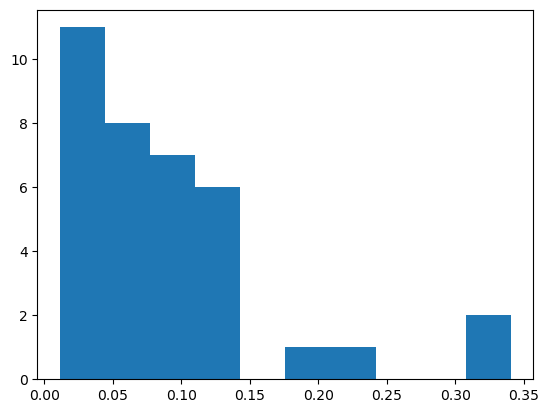

In [171]:
plt.hist(task_coinformations)

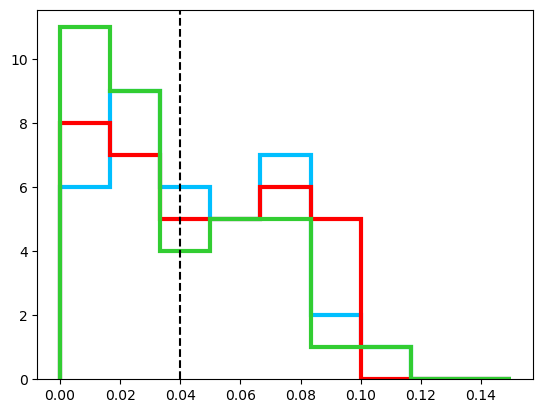

In [74]:
plt.hist([task_pids["Subject"+str(i)]['perm1'] for i in range(36)],histtype='step',linewidth=3,color='deepskyblue',bins=np.linspace(0,0.15,10));
plt.hist([task_pids["Subject"+str(i)]['perm2'] for i in range(36)],histtype='step',linewidth=3,color='red',bins=np.linspace(0,0.15,10));
plt.hist([task_pids["Subject"+str(i)]['perm3'] for i in range(36)],histtype='step',linewidth=3,color='limegreen',bins=np.linspace(0,0.15,10));
plt.axvline(0.04,c='black',ls='--')

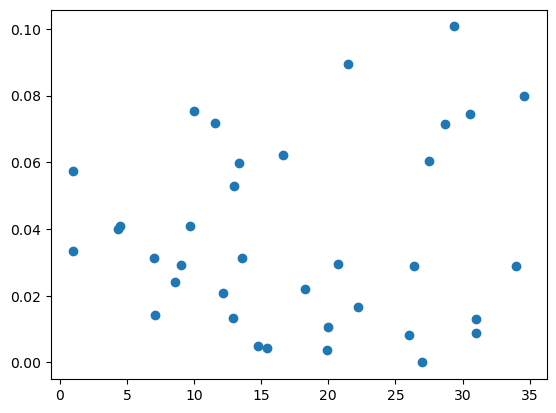

In [79]:
# plt.scatter(subject_performances['Number of subtractions'],[task_pids["Subject"+str(i)]['perm1'] for i in range(36)])
# plt.scatter(subject_performances['Number of subtractions'],[task_pids["Subject"+str(i)]['perm2'] for i in range(36)])
plt.scatter(subject_performances['Number of subtractions'],[task_pids["Subject"+str(i)]['perm3'] for i in range(36)])

0.06654394747670689 44.44444444444444


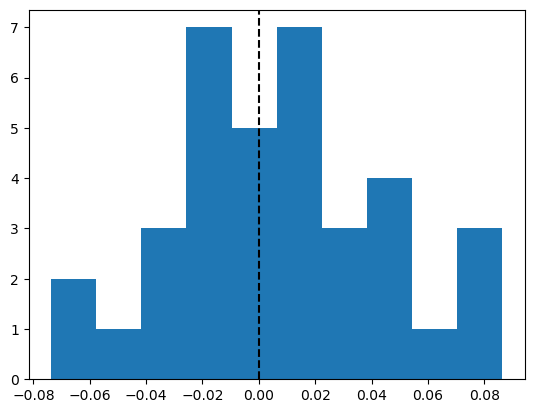

In [90]:
task_rest_diffs = [task_pids["Subject"+str(i)]['perm1']-rest_pids["Subject"+str(i)]['perm1'] for i in range(36)]
plt.hist(task_rest_diffs)
plt.axvline(0,ls='--',c='black')
print(skew(task_rest_diffs),percentileofscore(task_rest_diffs,0))

In [92]:
def get_all_ntuples(collection,n):
    return list(combinations(collection,n))

In [25]:
left_hemisphere_channels  = [channel[4:] for channel in valid_channels if int(channel[-1])%2 == 1]
right_hemisphere_channels = [channel[4:] for channel in valid_channels if int(channel[-1])%2 == 0]

In [26]:
left_hemisphere_channels

['Fp1', 'F3', 'F7', 'T3', 'C3', 'T5', 'P3', 'O1']

In [27]:
right_hemisphere_channels

['Fp2', 'F4', 'F8', 'T4', 'C4', 'T6', 'P4', 'O2']

In [134]:
# initialize list of lists 
data = [[['F4','F8','T4'],'F4, F8 → T4',0.5],[['F4','F8','T4'],'F4, T4 → F8',0.2]] 
 
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['TripletMembers','Permutation','{0:1}']) 
 
# print dataframe. 
df

,TripletMembers,Permutation,{0:1}
0,"[F4, F8, T4]","F4, F8 → T4",0.5
1,"[F4, F8, T4]","F4, T4 → F8",0.2


In [141]:
[memb for memb in df.TripletMembers if 'F4' in memb and 'F8' in memb and 'T4' in memb]

[['F4', 'F8', 'T4'], ['F4', 'F8', 'T4']]

In [111]:
rest_pids = {"Subject"+str(i):{} for i in range(36)}
for i in tqdm(list(range(36))):
    # --------------------------------------------------------------------------------------------read data
    raw     = mne.io.read_raw_edf(r"C:\Users\rober\NeuNet\ArithmeticTasks\Subject"+str(i)+"_1.edf",verbose=False);
    data_df = raw.to_data_frame()
    # --------------------------------------------------------------------------------------------choose 3 electrodes
    Electrode1 = data_df[T1]
    Electrode2 = data_df[T2]
    Electrode3 = data_df[T3]
    # --------------------------------------------------------------------------------------------binarize electrode signals
    binary1 = np.where(Electrode1>np.percentile(Electrode1,50),1,0)
    binary2 = np.where(Electrode2>np.percentile(Electrode2,50),1,0)
    binary3 = np.where(Electrode3>np.percentile(Electrode3,50),1,0)
    # --------------------------------------------------------------------------------------------compute PID for all 3 permutations of the electrodes
    distro3_1 = boolean_joint_distribution(binary1,binary2,binary3)
    pid3_1    = dit.pid.PID_WB(distro3_1).to_string()
    distro3_2 = boolean_joint_distribution(binary1,binary3,binary2)
    pid3_2    = dit.pid.PID_WB(distro3_2).to_string()
    distro3_3 = boolean_joint_distribution(binary2,binary3,binary1)
    pid3_3    = dit.pid.PID_WB(distro3_3).to_string()
    # --------------------------------------------------------------------------------------------store PID results
    rest_pids["Subject"+str(i)]['perm1'] = read_pid_table(pid3_1)['{0:1}']
    rest_pids["Subject"+str(i)]['perm2'] = read_pid_table(pid3_2)['{0:1}']
    rest_pids["Subject"+str(i)]['perm3'] = read_pid_table(pid3_3)['{0:1}']

0.0094

In [26]:
left_channels  = ['EEG Fp1', 'EEG F3', 'EEG F7', 'EEG T3', 'EEG C3', 'EEG T5', 'EEG P3', 'EEG O1']
right_channels = ['EEG Fp2', 'EEG F4', 'EEG F8', 'EEG T4', 'EEG C4', 'EEG T6', 'EEG P4', 'EEG O2']

left_triplets  = [frozenset(triplet) for triplet in combinations(right_channels,3)]
right_triplets = [frozenset(triplet) for triplet in combinations(right_channels,3)]

In [ ]:
for i in tqdm(list(range(36))):
    path            = r"C:\Users\rober\NeuNet\ArithmeticTasks\Subject"+str(i)+"_1.edf"
    raw_data        = load_subjet_data(path)
    useful_raw_data = only_useful_channels(raw_data)
    binary_data = binarize_data(useful_raw_data)
    for triplet in left_triplets:

In [11]:
a = frozenset(('c1','c2','c3'))
a

frozenset({'c1', 'c2', 'c3'})

In [12]:
b = frozenset(('c1','c2','c4'))

In [32]:
list(b)

['c1', 'c4', 'c2']

In [13]:
somedict = {a:[1,2,3],b:[10,11,12]}

In [16]:
somedict[frozenset(('c1','c3','c2'))]

[1, 2, 3]

In [5]:
sources,target = 'Fp2,F4-F8'.split('-')

In [6]:
sources

'Fp2,F4'

In [7]:
target

'F8'

In [9]:
s1,s2 = sources.split(',')
print(s1,s2)

Fp2 F4


In [3]:
import csv

my_dict = {"{0:1}": 1, "{0}": 2,"{1}": 2,"{0}{1}": 2}

with open("mycsvfile.csv", "w", newline="") as f:
    w = csv.DictWriter(f, my_dict.keys())
    w.writeheader()
    w.writerow(my_dict)

# FFT SURROGATES TESTS

In [203]:
n = 1000
t = np.linspace(0,10*np.pi,n)
X = np.sin(t)      + np.random.normal(0,0.01,n)
Y = np.sin(3*t)    + np.random.normal(0,0.01,n)
Z = np.sin(0.2*t) + np.random.normal(0,0.01,n)
XYZ = np.vstack([X,Y,Z])

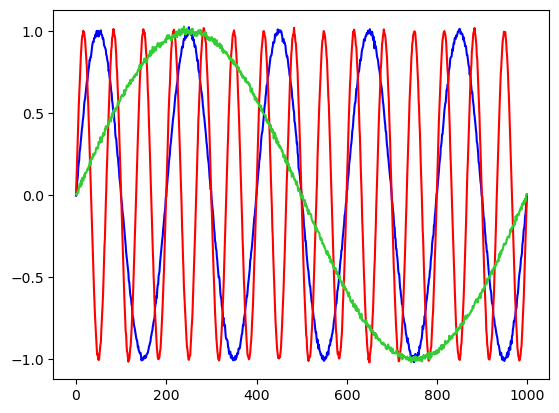

In [204]:
plt.plot(XYZ[0],c='blue')
plt.plot(XYZ[1],c='red')
plt.plot(XYZ[2],c='limegreen')

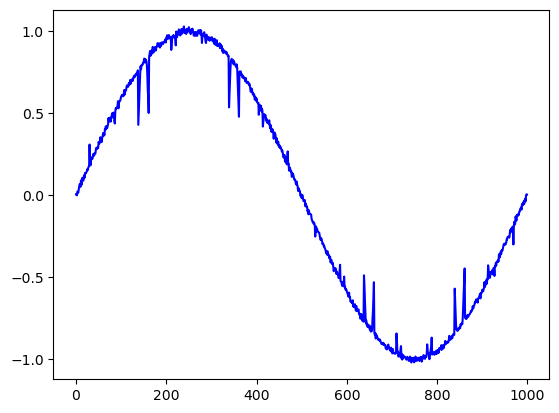

In [213]:
xyzfft = np.array(eng.generate_iAAFTn(XYZ))#np.asarray(eng.generate_iAAFTn(XYZ),order='K')
plt.plot(xyzfft[0],c='blue')
# plt.plot(xyzfft[1],c='red')
# plt.plot(xyzfft[2],c='limegreen')

In [214]:
np.corrcoef(xyzfft)

array([[ 1.        , -0.00519007,  0.01606002],
       [-0.00519007,  1.        , -0.01001455],
       [ 0.01606002, -0.01001455,  1.        ]])

In [215]:
np.corrcoef(XYZ)

array([[ 1.00000000e+00,  4.44312792e-04, -5.79919247e-04],
       [ 4.44312792e-04,  1.00000000e+00,  6.65263375e-04],
       [-5.79919247e-04,  6.65263375e-04,  1.00000000e+00]])

In [49]:
from statsmodels.tsa.stattools import acf

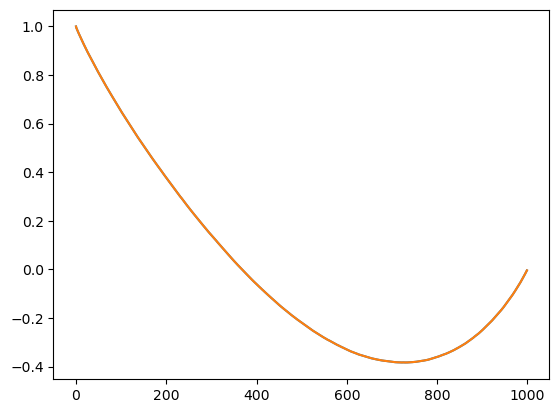

In [51]:
plt.plot(acf(xyzfft[2],nlags=len(X)))
plt.plot(acf(XYZ[2],nlags=len(X)))

In [73]:
print(X[:5])
print(Y[:5])
print(Z[:5])

[1 0 0 1 1]
[0 1 0 1 1]
[1 1 0 0 0]


In [51]:
dist = boolean_joint_distribution(X,Y,Z)
# dist = boolean_joint_distribution(X,X,X)

In [2]:
X,Y = np.random.randint(0,2,(2,10000))
Z = np.logical_xor(X,Y).astype(int)

k = int(0.01*len(X))
syns  = []
oinfs = []
tcors = []
dcors = []
for n in range(1,101):
    Y[:k*n] = X[:k*n]
    Z[:k*n] = X[:k*n]
    dist = boolean_joint_distribution(X,Y,Z)
    syns.append(read_pid_table(dit.pid.PID_WB(dist).to_string())['{0:1}'])
    oinfs.append(total_correlation(dist)-dual_total_correlation(dist))
    tcors.append(total_correlation(dist))
    dcors.append(dual_total_correlation(dist))

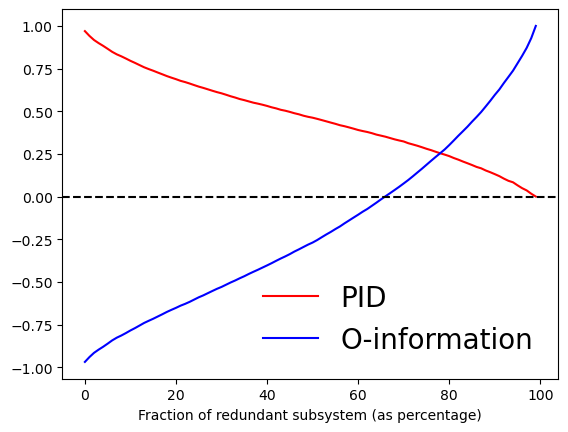

In [8]:
plt.plot(syns,c='red',label='PID')
plt.plot(oinfs,c='blue',label=r'O-information') 
plt.axhline(c='black',ls='--')


plt.xlabel('Fraction of redundant subsystem (as percentage)')
plt.legend(frameon=False,fontsize=20)

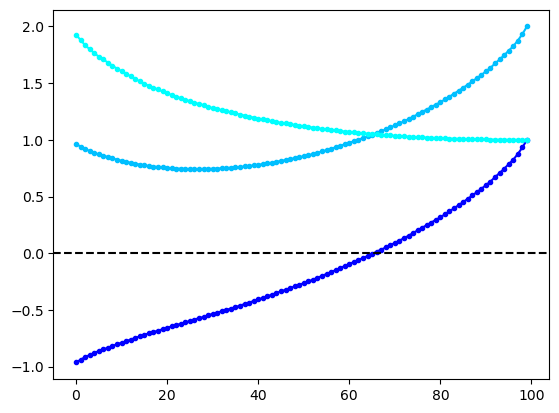

In [5]:
plt.plot(oinfs,c='blue',marker='.')
plt.plot(tcors,c='deepskyblue',marker='.')
plt.plot(dcors,c='cyan',marker='.')

plt.axhline(c='black',ls='--')
# plt.axvline(66,c='black',ls='--')

In [132]:
d = np.random.uniform(size=(3,10000)).T

cube1 = d[(0.5 <= d[:,0]) & (d[:,0] <= 1) & (d[:,1] < 0.5)  & (d[:,2] < 0.5)] 
cube2 = d[(d[:,0] < 0.5)  & (0.5 <= d[:,1]) & (d[:,1] <= 1) & (d[:,2] < 0.5)] 
cube3 = d[(d[:,0] < 0.5)  & (d[:,1] < 0.5)  & (0.5 <= d[:,2]) & (d[:,2] <= 1)] 
cube4 = d[(0.5 <= d[:,0]) & (d[:,0] <= 1) & (0.5 <= d[:,1]) & (d[:,1] <= 1) & (0.5 <= d[:,2]) & (d[:,2] <= 1)] 


allcubes = np.vstack((cube1,cube2,cube3,cube4))
x,y,z    = allcubes.T


xb = np.where(x<0.5,0,1)
yb = np.where(y<0.5,0,1)
zb = np.where(z<0.5,0,1)

distro = boolean_joint_distribution(xb,yb,zb)
print(dit.pid.PID_WB(distro))

print('\nΩ-information',total_correlation(distro)-dual_total_correlation(distro))

+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 1.0000 | 0.9997 |
|  {0}   | 0.0000 | 0.0000 |
|  {1}   | 0.0000 | 0.0000 |
| {0}{1} | 0.0000 | 0.0000 |
+--------+--------+--------+

Ω-information -0.9995667633251384


In [158]:
# C = np.array([[1,    0.3, -0.4],
#               [0.3,  1,    0.3],
#               [-0.4, 0.3,  1  ]])

C = np.array([[1,    0.5, 0.5],
              [0.5,  1,    0.5],
              [0.5, 0.5,  1  ]])

gx,gy,gz = 0.25*np.random.multivariate_normal(mean=np.zeros(3),cov=C,size=len(x)).T #multiplico por 0.25 para mandar a rango (-1,1)

In [171]:
ε = 0.5
A = (1-ε)*x + ε*gx
B = (1-ε)*y + ε*gy
C = (1-ε)*z + ε*gz

In [172]:
Ab = np.where(A<np.median(A),0,1)
Bb = np.where(B<np.median(B),0,1)
Cb = np.where(C<np.median(C),0,1)

distro = boolean_joint_distribution(Ab,Bb,Cb)
print(dit.pid.PID_WB(distro))

print('\nΩ-information',total_correlation(distro)-dual_total_correlation(distro))

+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.0667 | 0.0544 |
|  {0}   | 0.0123 | 0.0049 |
|  {1}   | 0.0074 | 0.0000 |
| {0}{1} | 0.0074 | 0.0074 |
+--------+--------+--------+

Ω-information -0.04702085926218702


In [141]:
gxb,gyb,gzb = np.where(gx<np.median(gx),0,1), np.where(gy<np.median(gy),0,1), np.where(gz<np.median(gz),0,1)

In [142]:
distro = boolean_joint_distribution(gxb,gyb,gzb)
print(dit.pid.PID_WB(distro))

print('\nΩ-information',total_correlation(distro)-dual_total_correlation(distro))

+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.1140 | 0.0378 |
|  {0}   | 0.0736 | 0.0000 |
|  {1}   | 0.0763 | 0.0027 |
| {0}{1} | 0.0736 | 0.0736 |
+--------+--------+--------+

Ω-information 0.03585348440154679


# Ordinal Pattern Symbolization

In [56]:
from ordpy import ordinal_sequence

def Oinfo(*rvs):
    joint_symbols,freqs = np.unique(list(zip(*rvs)), axis=0, return_counts=True)
    symbol_strings      = list(map(joint_symbols_to_string,joint_symbols))
    distribution        = dit.Distribution(symbol_strings, frequencies/sum(frequencies))
    O                   = total_correlation(distribution)-dual_total_correlation(distribution)
    return O

def PID(*rvs):
    joint_symbols,freqs = np.unique(list(zip(*rvs)), axis=0, return_counts=True)
    symbol_strings      = list(map(joint_symbols_to_string,joint_symbols))
    distribution        = dit.Distribution(symbol_strings, freqs/sum(freqs))
    pid                 = dit.pid.PID_WB(distribution)
    syn                 = read_pid_table(pid)['{0:1}']
    return syn    

def joint_symbols_to_string(symbols):
    return np.array2string(symbols,separator='')[1:-1]

In [48]:
translation = {(0,1,2):'a',(0,2,1):'b',(2,0,1):'c',(1,0,2):'d',(2,1,0):'e',(1,2,0):'f'}
# translation = {(0,1):'a',(1,0):'b'}

In [50]:
patts1 = [tuple(patt) for patt in ordinal_sequence(data_df['EEG Fz'], overlapping=False,dx=3,taux=1)]
patts1 = [translation[pi] for pi in patts1]

In [51]:
patts2 = [tuple(patt) for patt in ordinal_sequence(data_df['EEG Cz'], overlapping=False,dx=3,taux=1)]
patts2 = [translation[pi] for pi in patts2]

In [52]:
patts3 = [tuple(patt) for patt in ordinal_sequence(data_df['EEG Pz'], overlapping=False,dx=3,taux=1)]
patts3 = [translation[pi] for pi in patts3]

In [53]:
joint_symbols,frequencies = np.unique(list(zip(patts1,patts2,patts3)), axis=0, return_counts=True)
symbol_strings            = list(map(joint_symbols_to_string,joint_symbols))
distribution              = dit.Distribution(symbol_strings, frequencies/sum(frequencies))

In [54]:
Oinfo(patts1,patts2,patts3)

0.030124973467538396

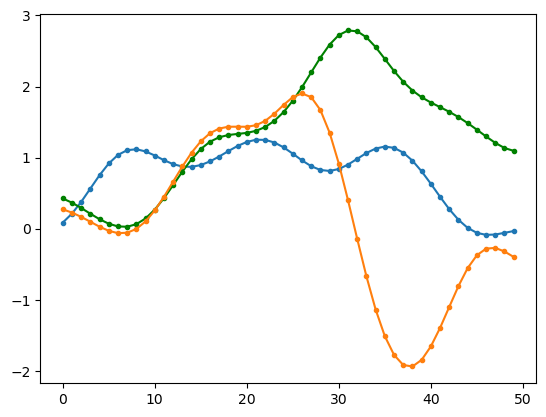

In [124]:
plt.plot(data_df['EEG Fp1'][:50]/8,marker='.')
plt.plot(data_df['EEG F3'][:50]/5+1,marker='.',c='g')
plt.plot(data_df['EEG F7'][:50]/3+1,marker='.')

In [6]:
data_df.head()

,time,EEG Fp1,EEG Fp2,EEG F3,EEG F4,EEG F7,EEG F8,EEG T3,EEG T4,EEG C3,...,EEG T6,EEG P3,EEG P4,EEG O1,EEG O2,EEG Fz,EEG Cz,EEG Pz,EEG A2-A1,ECG ECG
0,0.000,0.702551,1.643944,-2.866200,-0.464799,-2.178186,3.606373,-3.276975,0.521170,-4.598714,...,9.226611,-5.113455,-4.681637,-4.390680,-3.607114,-2.059685,-6.639033,-8.576595,3.912944,151.092187
1,0.002,1.710210,1.710306,-3.162531,-0.493239,-2.314559,3.199665,-3.055752,-0.366925,-4.772858,...,9.267242,-5.455914,-5.919727,-5.221906,-5.250818,-2.268242,-6.772593,-9.270012,2.813116,85.423561
2,0.004,3.030086,1.756248,-3.533838,-0.561753,-2.495127,2.714239,-2.656927,-1.586263,-4.816394,...,9.141286,-5.668794,-7.478527,-5.988110,-7.277746,-2.498009,-6.782133,-10.015565,1.253524,-3.406119
3,0.006,4.533686,1.748591,-3.938467,-0.681977,-2.702212,2.209135,-2.055575,-3.054685,-4.633824,...,8.818270,-5.641027,-9.203276,-6.534645,-9.487821,-2.708922,-6.565893,-10.686389,-0.689204,-109.137106
4,0.008,6.037285,1.656706,-4.325244,-0.859080,-2.910560,1.752135,-1.257926,-4.628739,-4.166164,...,8.344918,-5.303196,-10.892598,-6.777159,-11.657881,-2.859743,-6.050732,-11.159094,-2.856406,-221.968991


In [7]:
data_df = data_df.drop(columns=['time'])
data_df.head()

,EEG Fp1,EEG Fp2,EEG F3,EEG F4,EEG F7,EEG F8,EEG T3,EEG T4,EEG C3,EEG C4,...,EEG T6,EEG P3,EEG P4,EEG O1,EEG O2,EEG Fz,EEG Cz,EEG Pz,EEG A2-A1,ECG ECG
0,0.702551,1.643944,-2.866200,-0.464799,-2.178186,3.606373,-3.276975,0.521170,-4.598714,-6.103448,...,9.226611,-5.113455,-4.681637,-4.390680,-3.607114,-2.059685,-6.639033,-8.576595,3.912944,151.092187
1,1.710210,1.710306,-3.162531,-0.493239,-2.314559,3.199665,-3.055752,-0.366925,-4.772858,-6.539318,...,9.267242,-5.455914,-5.919727,-5.221906,-5.250818,-2.268242,-6.772593,-9.270012,2.813116,85.423561
2,3.030086,1.756248,-3.533838,-0.561753,-2.495127,2.714239,-2.656927,-1.586263,-4.816394,-7.032973,...,9.141286,-5.668794,-7.478527,-5.988110,-7.277746,-2.498009,-6.782133,-10.015565,1.253524,-3.406119
3,4.533686,1.748591,-3.938467,-0.681977,-2.702212,2.209135,-2.055575,-3.054685,-4.633824,-7.500212,...,8.818270,-5.641027,-9.203276,-6.534645,-9.487821,-2.708922,-6.565893,-10.686389,-0.689204,-109.137106
4,6.037285,1.656706,-4.325244,-0.859080,-2.910560,1.752135,-1.257926,-4.628739,-4.166164,-7.853530,...,8.344918,-5.303196,-10.892598,-6.777159,-11.657881,-2.859743,-6.050732,-11.159094,-2.856406,-221.968991


In [16]:
data_np = data_df.to_numpy()
data_np.shape

(30001, 21)

In [14]:
data_C = data_df.corr()

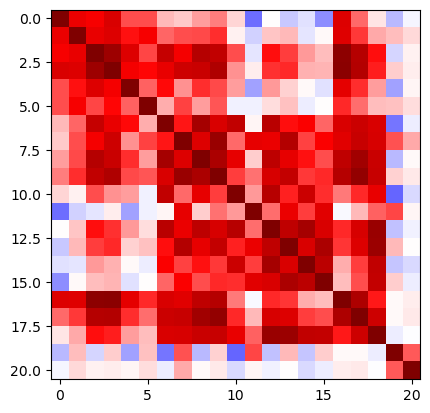

In [15]:
plt.imshow(data_C,vmin=-1,vmax=1,cmap='seismic')

In [18]:
data_ss = cholesky_surrogates(data_np.T)

In [20]:
surr_C = np.corrcoef(data_ss)

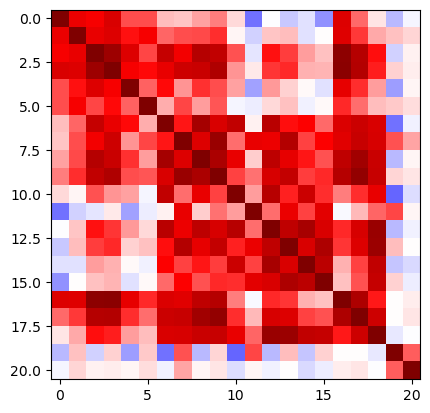

In [21]:
plt.imshow(surr_C,vmin=-1,vmax=1,cmap='seismic')

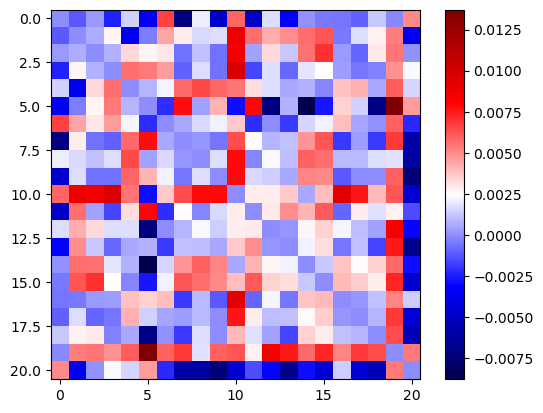

In [24]:
plt.imshow(data_C-surr_C,cmap='seismic')
plt.colorbar()

In [27]:
data_ss.T

(30001, 21)

In [29]:
data_df.columns

'EEG Fp1'

In [30]:
surr_df = pd.DataFrame(data_ss.T, columns=data_df.columns)

In [31]:
surr_df

,EEG Fp1,EEG Fp2,EEG F3,EEG F4,EEG F7,EEG F8,EEG T3,EEG T4,EEG C3,EEG C4,...,EEG T6,EEG P3,EEG P4,EEG O1,EEG O2,EEG Fz,EEG Cz,EEG Pz,EEG A2-A1,ECG ECG
0,-0.180989,0.042355,0.845941,0.508735,1.268826,-0.988804,0.452030,-0.141948,0.370813,0.000284,...,-0.240035,-0.502104,-1.079922,-0.724097,-1.051266,0.606080,0.069442,-0.946477,1.047438,0.166100
1,-0.257574,-0.636715,-1.190407,-0.536221,-1.130578,-0.388080,-0.896976,0.296848,-0.673946,-0.498221,...,0.679233,-0.154149,0.590122,0.104950,0.296581,-0.749128,-1.117477,-0.075617,-0.233499,0.441183
2,-0.043490,-0.707416,-0.628509,-0.183378,-0.024783,0.235782,-0.044902,0.747920,-0.230624,0.153011,...,1.245602,1.264977,1.507759,1.194198,1.861340,-0.847382,-0.154618,1.666920,-0.365596,0.425467
3,-0.334791,0.542665,-1.038961,-0.821664,-0.075034,0.332781,-0.437483,-0.487813,-0.779113,-0.339026,...,-1.237794,-0.039030,0.019513,1.633200,1.010416,-0.980571,-0.761163,0.329316,0.194541,0.898935
4,1.340091,0.139164,0.600966,0.677386,0.131657,-1.015236,0.079981,-0.018067,0.630332,0.290132,...,0.047366,0.057155,0.116201,0.572994,-0.140448,0.309999,0.154253,0.055207,-1.338213,-1.484908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-0.853191,0.264594,-0.000103,-0.896090,-1.179215,1.389984,-0.335896,-0.925238,0.104178,-0.696883,...,-1.112147,0.058682,-0.276184,0.048023,0.011090,-0.750465,-0.261797,0.104641,0.082168,0.767710
29997,1.711894,0.117208,0.309051,0.363954,2.356356,-0.497491,0.577200,-1.024432,0.191673,-0.561675,...,-0.118683,0.601673,-0.941645,1.198142,0.056565,0.719971,-0.326153,-0.169946,-2.139039,-2.046752
29998,0.747760,0.150407,0.654025,0.672255,0.353357,0.477107,-0.220455,0.440597,0.229006,0.059996,...,0.528824,-0.008547,0.045528,-0.088896,-0.337426,0.693277,-0.130854,-0.291636,-0.369723,0.251427
29999,-1.531333,-0.834918,0.056629,-0.485845,0.454931,-0.960403,0.043599,0.222689,0.547559,0.420769,...,0.566226,-0.559112,-0.052702,-0.722567,-0.160431,0.073281,0.431787,-0.217995,0.065945,0.536672


<Axes: >

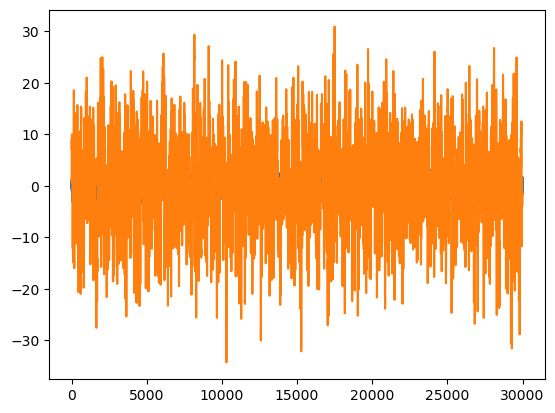

In [33]:
surr_df['EEG Fp1'].plot()
data_df['EEG Fp1'].plot()

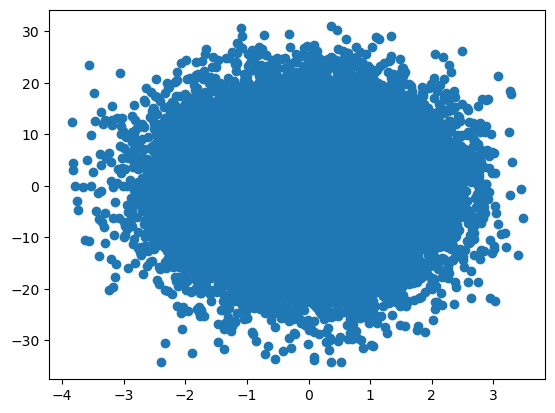

In [34]:
plt.scatter(surr_df['EEG Fp1'],data_df['EEG Fp1'])

In [8]:
def generate_surrogates(data_df:pd.DataFrame) -> pd.DataFrame:
    """
    Creates Cholesky a sample of surrogate data via Cholesky decomposition.
    Parameters:
        data_df: a dataframe containing only the useful columns of the EEG
    Returns:
        surrogate_df: a dataframe containing the Cholesky surrogates
    """
    def cholesky_surrogates(series):
        s = np.copy(series)

        for i in range(len(s)):
            s[i] = np.random.permutation(s[i])
            s[i] = (s[i]-np.mean(s[i]))/np.std(s[i])
        pearson_corr  = np.corrcoef(series)
        x             = s
        c             = cholesky(pearson_corr, lower=True)
        choles        = np.dot(c, x)
        return choles
    data_array      = data_df.to_numpy()
    surrogate_array = cholesky_surrogates(data_array.T)
    surrogate_df    = pd.DataFrame(surrogate_array.T,columns=data_df.columns)
    return surrogate_df

In [10]:
surro_df = generate_surrogates(data_df)

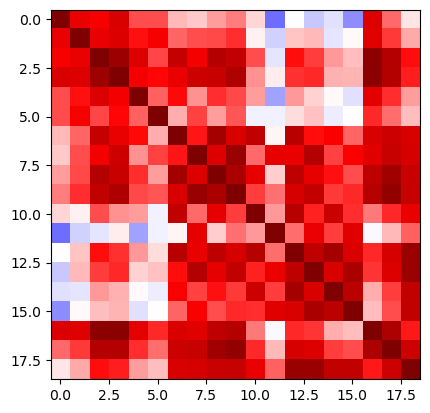

In [6]:
plt.imshow(data_df.corr(),vmin=-1,vmax=1,cmap='seismic')

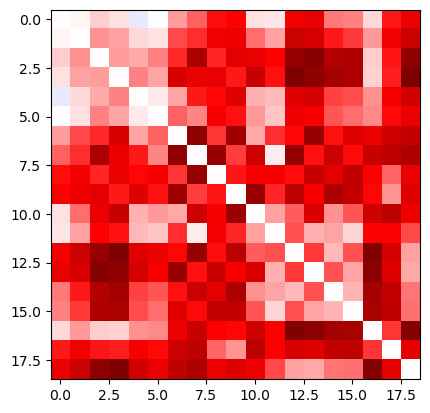

In [8]:
plt.imshow(data_df.corr()-data_df_reref.corr(),vmin=-1,vmax=1,cmap='seismic')

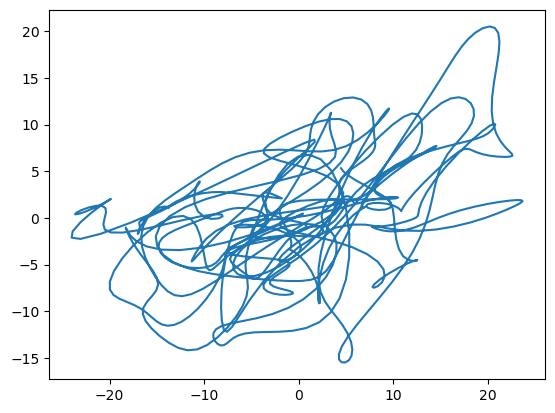

In [13]:
plt.plot(data_df_reref['EEG F8'][:1000],data_df_reref['EEG F4'][:1000])
plt.xlabel('F8')
plt.ylabel('F4')

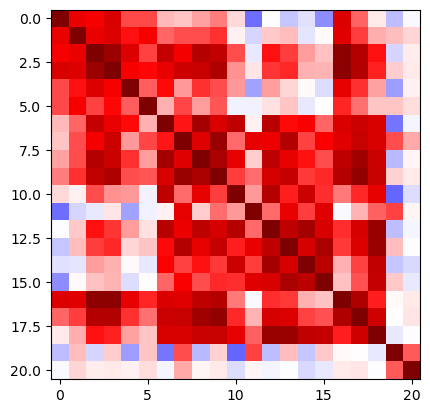

In [13]:
plt.imshow(surro_df.corr(),vmin=-1,vmax=1,cmap='seismic')

In [5]:
plt.imshow(data_df.corr()-surro_df.corr(),cmap='seismic')
plt.colorbar()

NameError: name 'surro_df' is not defined

In [30]:
def cholesky_surrogates(series):
    pearson_corr  = np.corrcoef(series)
    x             = np.random.normal(size=series.shape)
    c             = cholesky(pearson_corr, lower=True)
    choles        = np.dot(c, x)
    return choles

In [4]:
def generate_surrogates(data_df:pd.DataFrame) -> pd.DataFrame:
    """
    Creates a sample of surrogate data via Cholesky decomposition.
    Parameters:
        data_df: a dataframe containing only the useful columns of the EEG data
    Returns:
        surrogate_df: a dataframe containing the Cholesky surrogates
    """
    def cholesky_surrogates(series):
        pearson_corr  = np.corrcoef(series)
        x             = np.random.normal(size=series.shape)
        c             = cholesky(pearson_corr, lower=True)
        choles        = np.dot(c, x)
        return choles       
    data_array      = data_df.to_numpy().T
    surrogate_array = cholesky_surrogates(data_array).T
    surrogate_df    = pd.DataFrame(surrogate_array,columns=data_df.columns)
    return surrogate_df

In [5]:
series = data_df.to_numpy().T

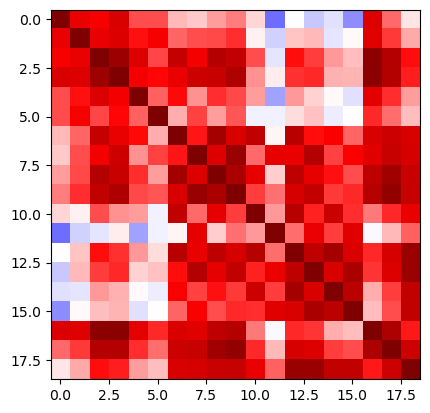

In [32]:
plt.imshow(np.corrcoef(series),vmin=-1,vmax=1,cmap='seismic')

In [6]:
chss = generate_surrogates(data_df).to_numpy().T

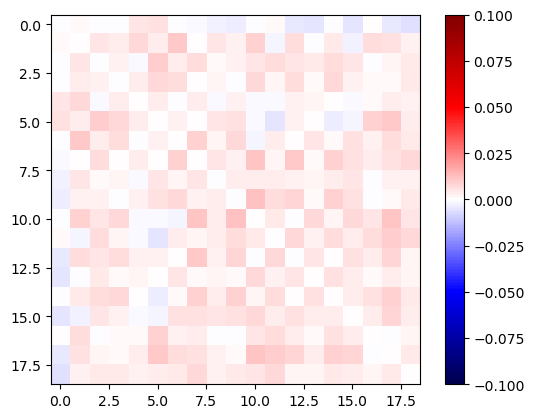

In [8]:
plt.imshow(np.corrcoef(series)-np.corrcoef(chss),vmin=-0.1,vmax=0.1,cmap='seismic')
plt.colorbar()

In [27]:


def joint_symbols_to_string(symbols):
    return np.array2string(symbols,separator='')[1:-1]

def partial_info_decomp(r1,r2,r3):
    joint_symbols,freqs = np.unique(list(zip(r1,r2,r3)), axis=0, return_counts=True)
    symbol_strings      = list(map(joint_symbols_to_string,joint_symbols))
    distribution        = dit.Distribution(symbol_strings, freqs/sum(freqs))
    pid                 = dit.pid.PID_WB(distribution)
    return read_pid_table(str(pid))

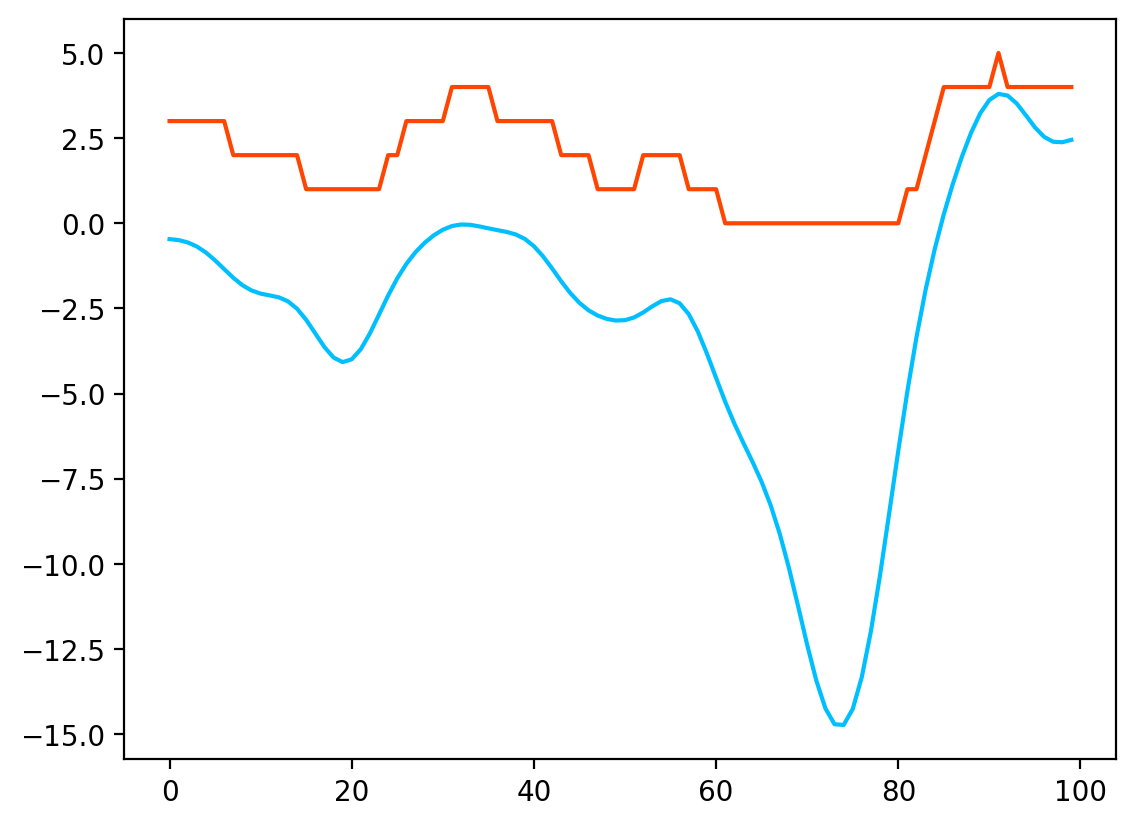

In [28]:
plt.plot(symbolize(data_df['EEG F4'].to_numpy()[:100],[20,40,60,80,100]),c='orangered')
plt.plot(data_df['EEG F4'].to_numpy()[:100],c='deepskyblue')

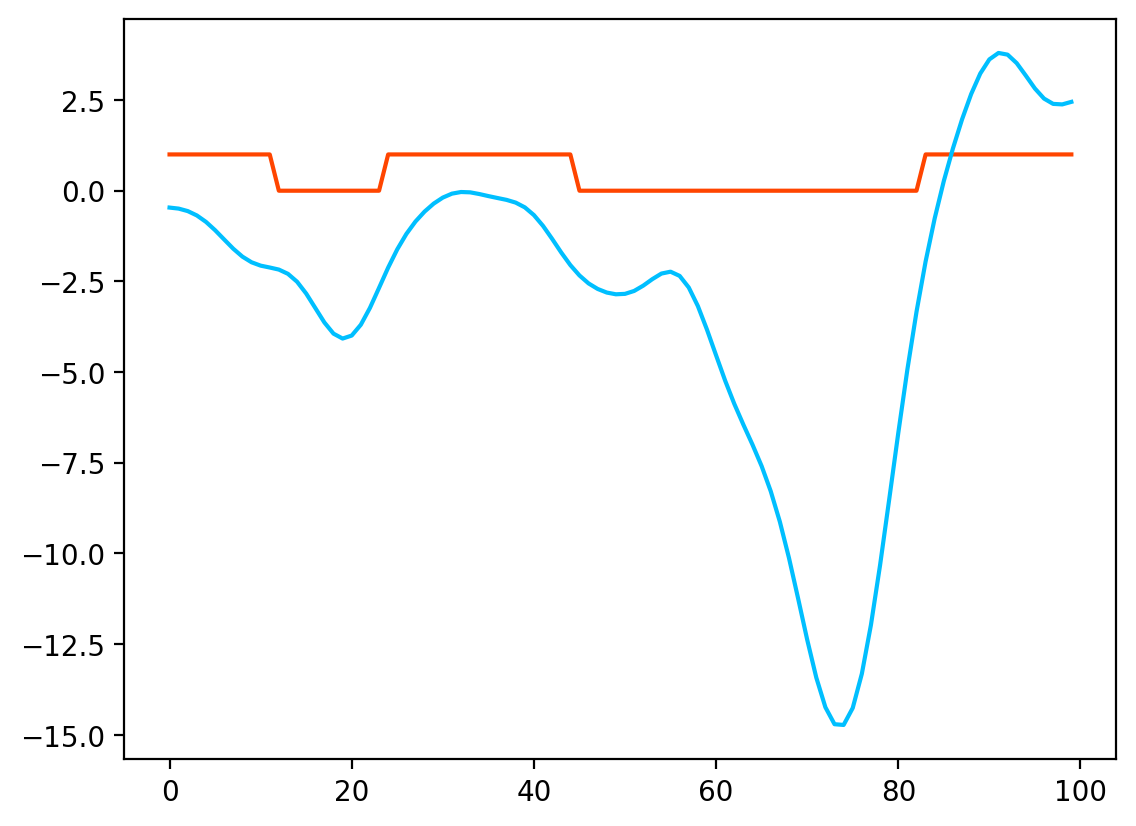

In [28]:
plt.plot(symbolize(data_df['EEG F4'].to_numpy()[:100],[50]),c='orangered')
plt.plot(data_df['EEG F4'].to_numpy()[:100],c='deepskyblue')

In [84]:
print(pid)

+--------+--------+--------+
| I_min  |  I_r   |   pi   |
+--------+--------+--------+
| {0:1}  | 0.0089 | 0.0063 |
|  {0}   | 0.0021 | 0.0000 |
|  {1}   | 0.0020 | 0.0000 |
| {0}{1} | 0.0015 | 0.0015 |
+--------+--------+--------+


In [99]:
s1 = symbolize(data_df['EEG F4'],[20,40,60,80,100])[:]
s2 = symbolize(data_df['EEG F8'],[20,40,60,80,100])[:]
s3 = symbolize(data_df['EEG Fp2'],[20,40,60,80,100])[:]

partial_info_decomp(s1,s2,s3)

{'{0:1}': 0.0827, '{0}': 0.089, '{1}': 0.0, '{0}{1}': 0.1995}

In [92]:
s1 = np.random.permutation(symbolize(data_df['EEG F3'],[20,40,60,80,100])[:])
s2 = np.random.permutation(symbolize(data_df['EEG F7'],[20,40,60,80,100])[:])
s3 = np.random.permutation(symbolize(data_df['EEG Fp1'],[20,40,60,80,100])[:])

joint_symbols,freqs = np.unique(list(zip(s1,s2,s3)), axis=0, return_counts=True)
symbol_strings      = list(map(joint_symbols_to_string,joint_symbols))
distribution        = dit.Distribution(symbol_strings, freqs/sum(freqs))
pid                 = dit.pid.PID_WB(distribution)
syn                 = read_pid_table(str(pid))['{0:1}']
red                 = read_pid_table(str(pid))['{0}{1}']  
print(syn,red)

0.0083 0.0


# <font size=20><center>Moving window analyses

In [8]:
from more_itertools import windowed

In [9]:
def rolling_window(series,size,step):
    return [np.array(w) for w in windowed(series,n=size,step=step)]

In [11]:
size,step = 2000,1000

#---------- LOCAL BINARIZATION ----------
# wsch1 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG Fp1'],size,step)[:-1]]
# wsch2 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F3'],size,step)[:-1]]
# wsch3 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F7'],size,step)[:-1]]
# wsch4 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG C3'],size,step)[:-1]]

#---------- GLOBAL BINARIZATION ----------
binarych1 = np.where(data_df['EEG Fp1']>np.median(data_df['EEG Fp1']),1,0)
binarych2 = np.where(data_df['EEG F3']>np.median(data_df['EEG F3']),1,0)
binarych3 = np.where(data_df['EEG F7']>np.median(data_df['EEG F7']),1,0)
binarych4 = np.where(data_df['EEG C3']>np.median(data_df['EEG C3']),1,0)
wsch1     = [w for w in rolling_window(binarych1,size,step)[:-1]]
wsch2     = [w for w in rolling_window(binarych2,size,step)[:-1]]
wsch3     = [w for w in rolling_window(binarych3,size,step)[:-1]]
wsch4     = [w for w in rolling_window(binarych4,size,step)[:-1]]

In [12]:
OI3 = [Oinfo(w1,w2,w3) for w1,w2,w3 in zip(wsch1,wsch2,wsch3)]

In [13]:
OI3rnd = [Oinfo(np.random.permutation(w1),np.random.permutation(w2),np.random.permutation(w3))
          for w1,w2,w3 in zip(wsch1,wsch2,wsch3)]

Text(0.5, 0, 'Window #')

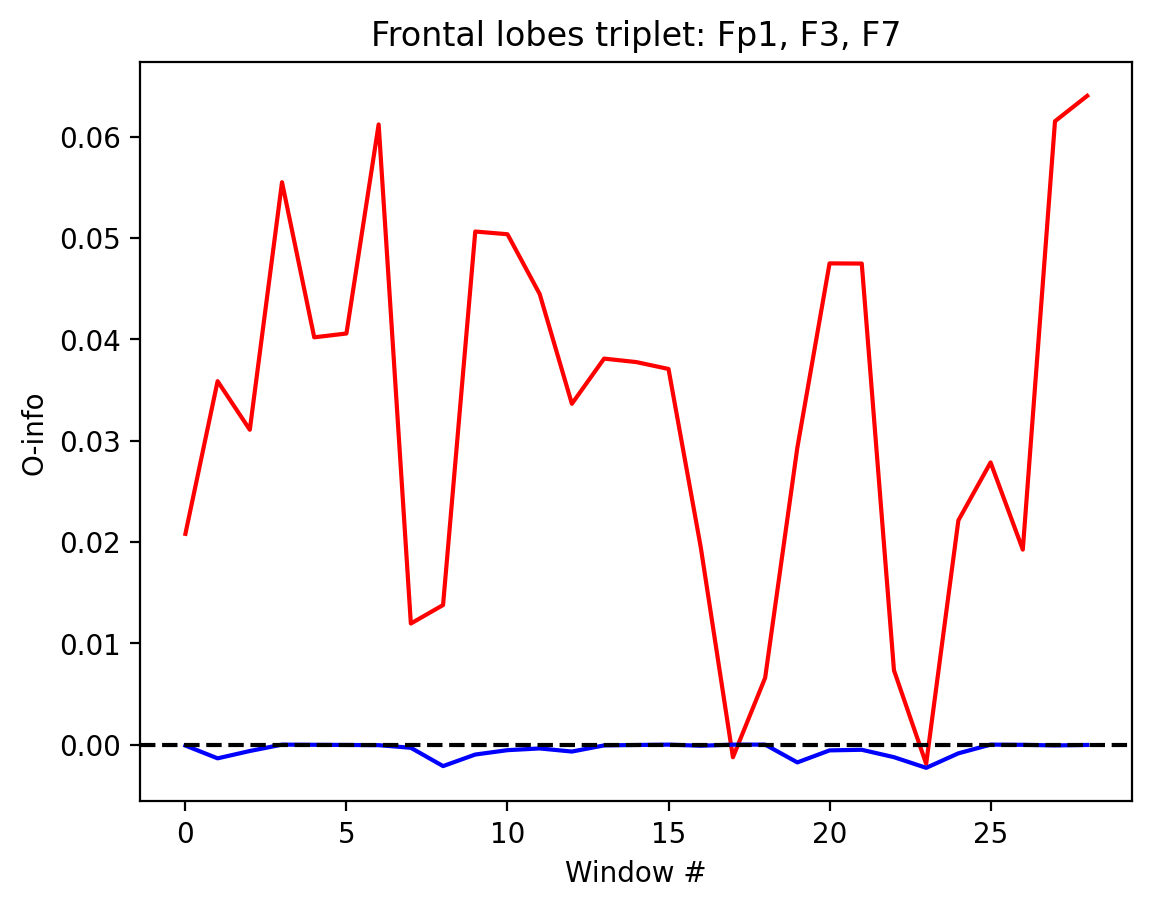

In [14]:
plt.plot(OI3,c='red')
plt.plot(OI3rnd,c='blue')
plt.axhline(ls='--',c='black')
plt.title('Frontal lobes triplet: Fp1, F3, F7')
plt.ylabel('O-info')
plt.xlabel('Window #')

In [18]:
OI3 = [Oinfo(w1,w2,w4) for w1,w2,w4 in zip(wsch1,wsch2,wsch4)]

In [19]:
OI3rnd = [Oinfo(np.random.permutation(w1),np.random.permutation(w2),w4)
          for w1,w2,w4 in zip(wsch1,wsch2,wsch4)]

Text(0.5, 0, 'Window #')

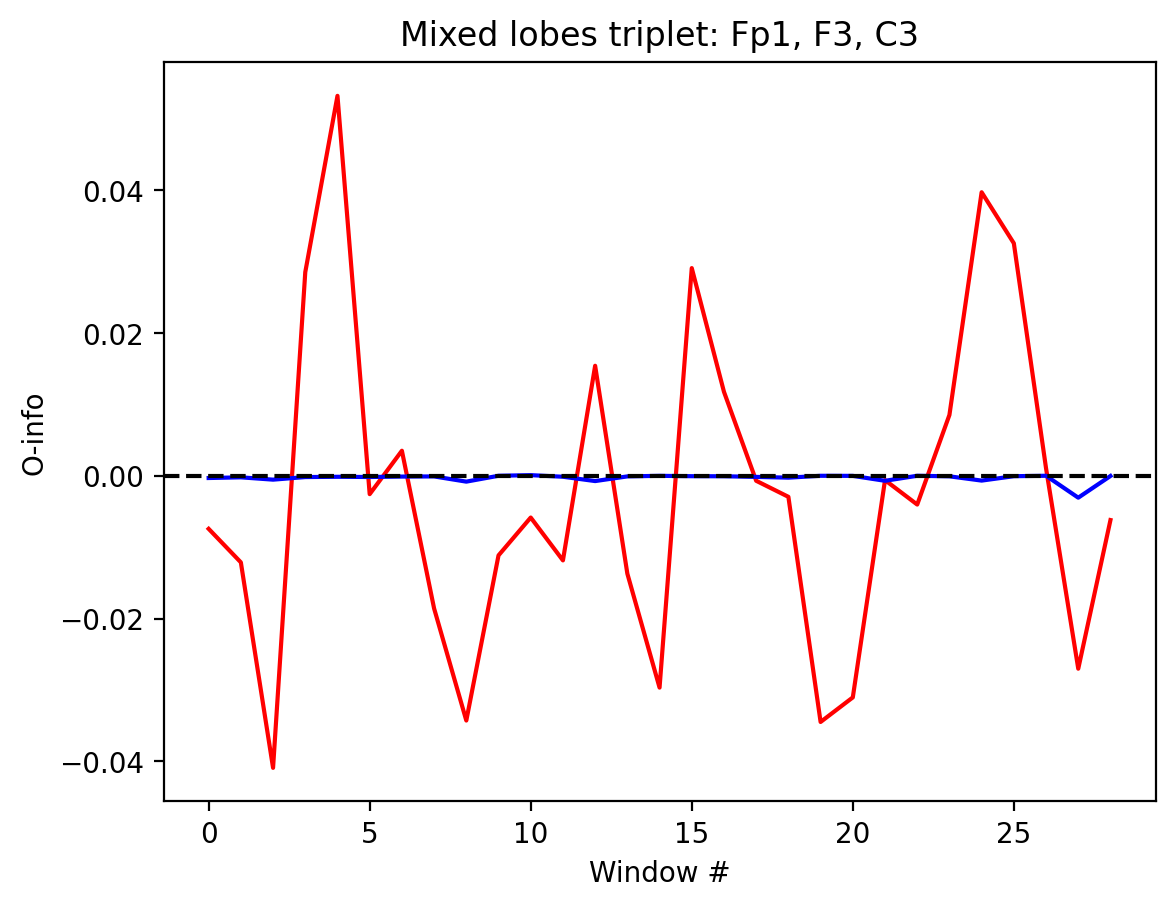

In [20]:
plt.plot(OI3,c='red')
plt.plot(OI3rnd,c='blue')
plt.axhline(ls='--',c='black')
plt.title('Mixed lobes triplet: Fp1, F3, C3')
plt.ylabel('O-info')
plt.xlabel('Window #')

### now a quadruplet

In [105]:
OI4    = [Oinfo(w1,w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

OI4rnd = [Oinfo(np.random.permutation(w1),
                np.random.permutation(w2),
                np.random.permutation(w3),
                np.random.permutation(w4)) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

OI4ctrl1 = [Oinfo(np.random.permutation(w1),w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl2 = [Oinfo(np.random.permutation(w2),w1,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl3 = [Oinfo(np.random.permutation(w3),w1,w2,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl4 = [Oinfo(np.random.permutation(w4),w1,w2,w3) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

Text(0.5, 1.0, 'Fp1, F3, F7, C3')

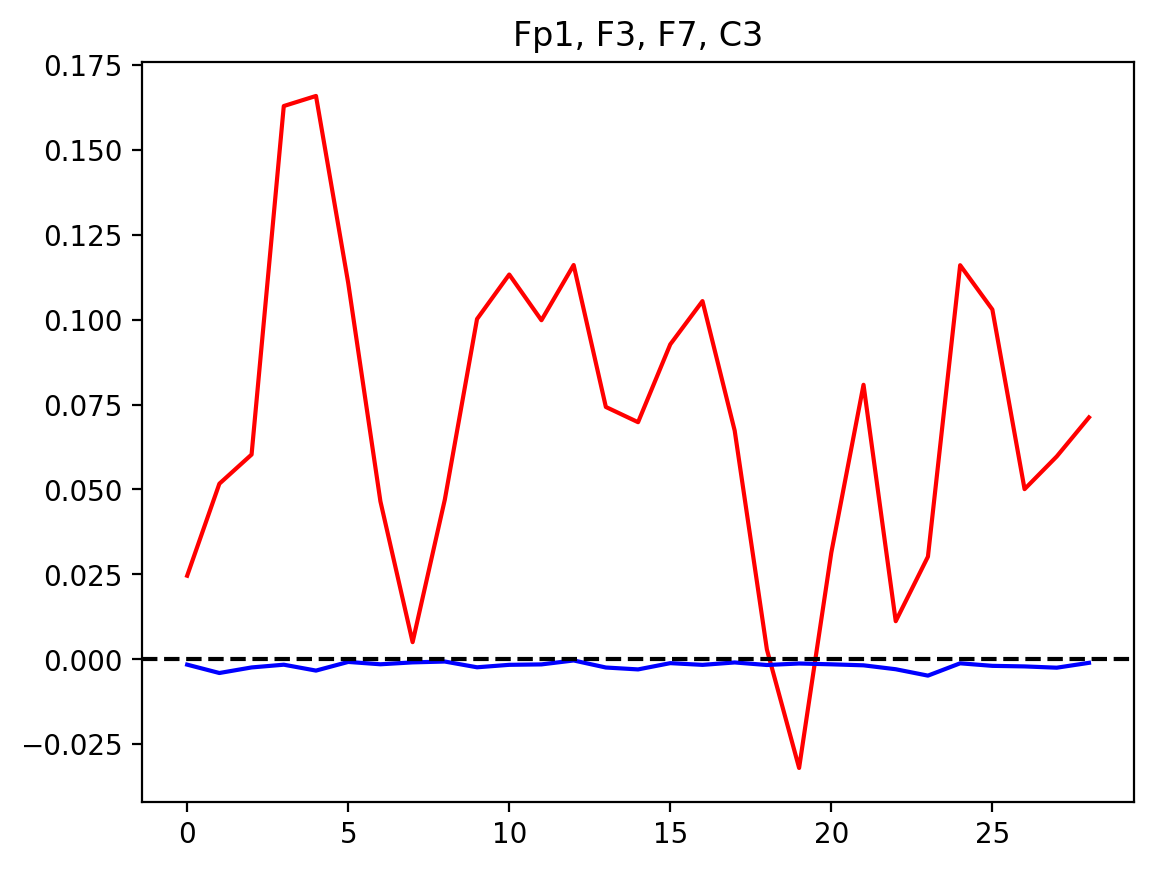

In [106]:
plt.plot(OI4,c='red')
plt.plot(OI4rnd,c='blue')
plt.axhline(ls='--',c='black')
plt.title('Fp1, F3, F7, C3')

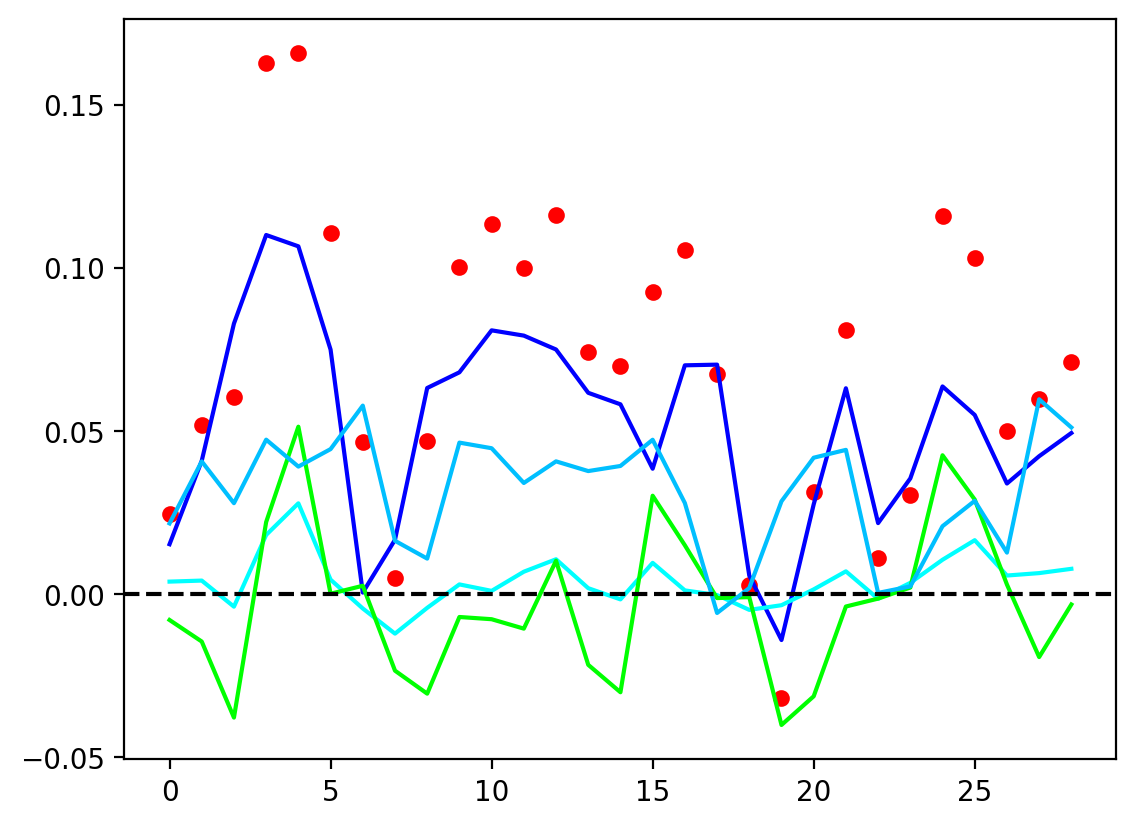

In [107]:
plt.plot(OI4,c='red',marker='.',ms=10,ls='-',lw=0)
plt.plot(OI4ctrl1,c='blue')
plt.plot(OI4ctrl2,c='cyan')
plt.plot(OI4ctrl3,c='lime')
plt.plot(OI4ctrl4,c='deepskyblue')
plt.axhline(ls='--',c='black')

### Now across hemispheres

#### Across lobes

In [129]:
size,step = 2000,1000
wsch1 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F3'],size,step)[:-1]]
wsch2 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F7'],size,step)[:-1]]
wsch3 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG P4'],size,step)[:-1]]
wsch4 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG T6'],size,step)[:-1]]

In [130]:
OI4    = [Oinfo(w1,w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

# OI4rnd = [Oinfo(np.random.permutation(w1),
#                 np.random.permutation(w2),
#                 np.random.permutation(w3),
#                 np.random.permutation(w4)) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

# OI4ctrl1 = [Oinfo(np.random.permutation(w1),w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl2 = [Oinfo(np.random.permutation(w2),w1,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl3 = [Oinfo(np.random.permutation(w3),w1,w2,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl4 = [Oinfo(np.random.permutation(w4),w1,w2,w3) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

OI4ctrl1 = [Oinfo(w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl2 = [Oinfo(w1,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl3 = [Oinfo(w1,w2,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl4 = [Oinfo(w1,w2,w3) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

Text(0.5, 1.0, 'F3, F7, P4, T6')

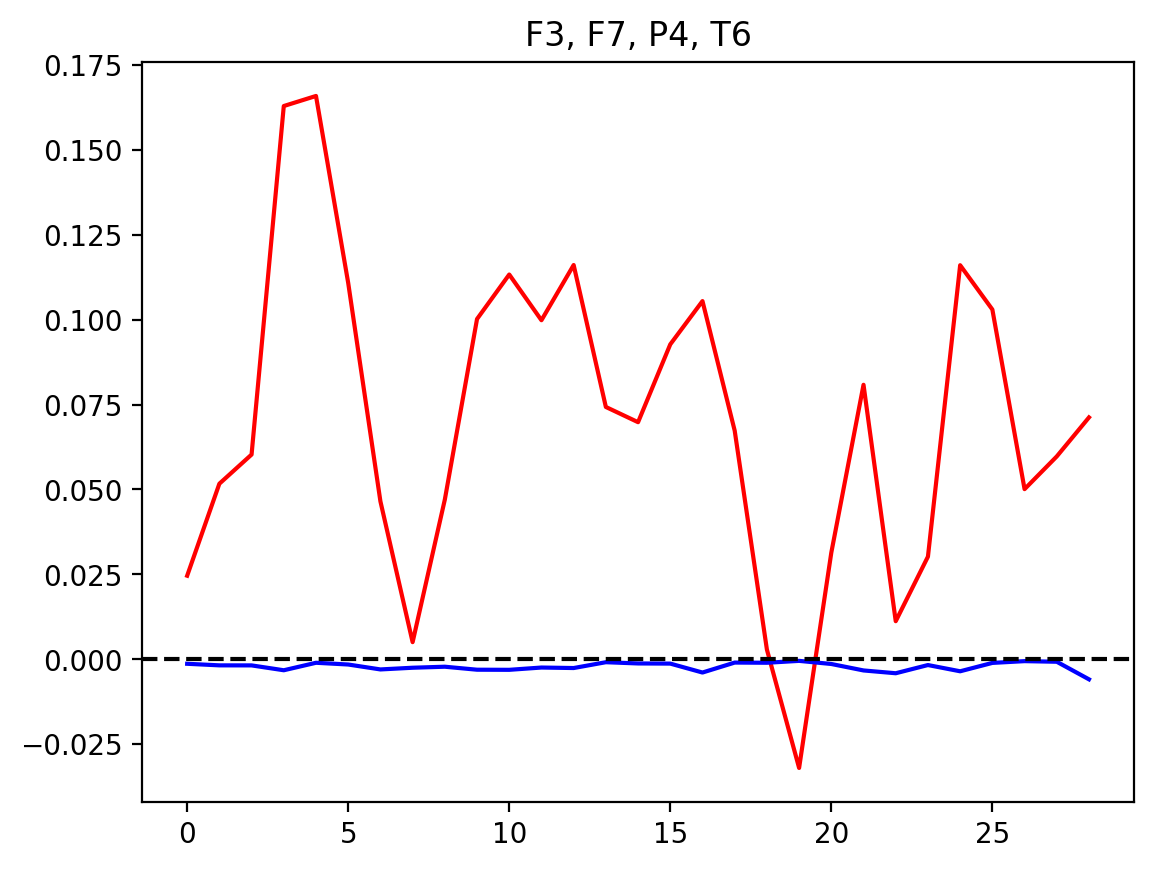

In [123]:
plt.plot(OI4,c='red')
plt.plot(OI4rnd,c='blue')
plt.axhline(ls='--',c='black')
plt.title('F3, F7, P4, T6')

Text(0.5, 1.0, 'F3, F7, P4, T6')

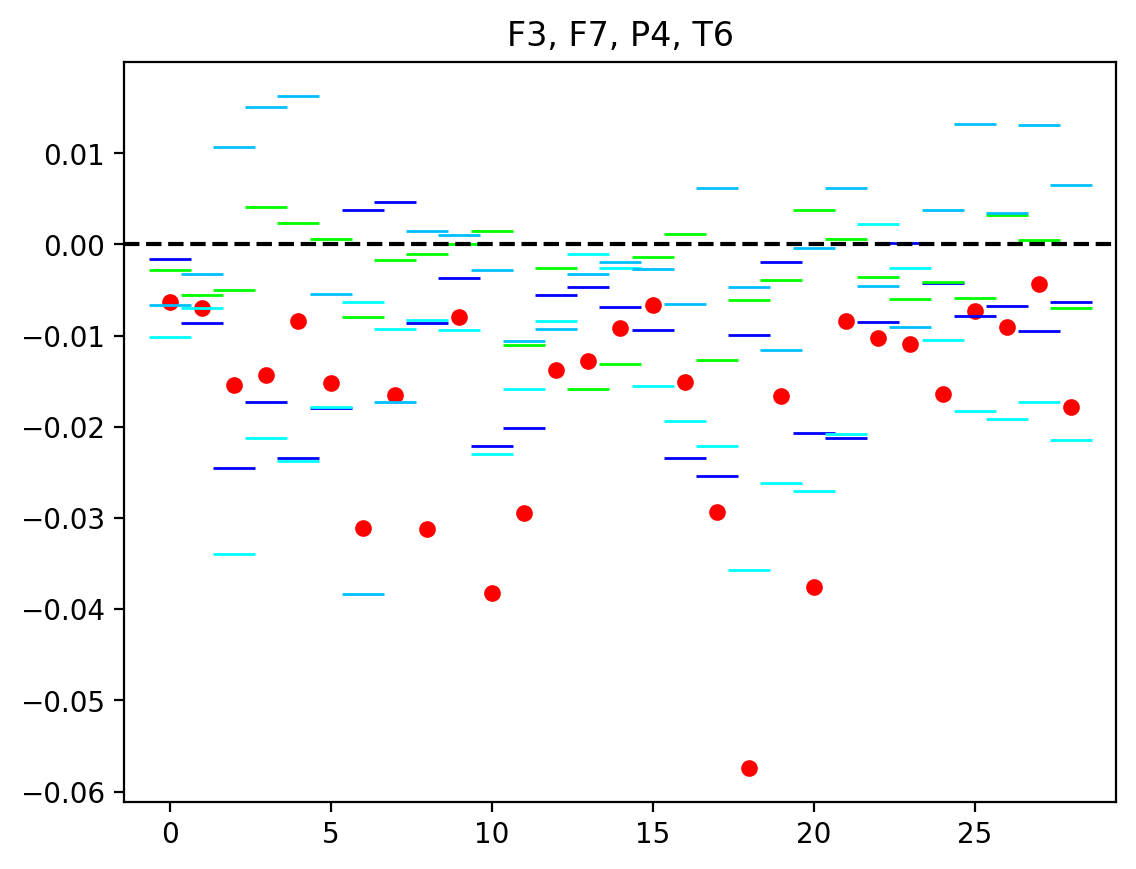

In [133]:
plt.plot(OI4,c='red',marker='.',ms=10,ls='')
plt.plot(OI4ctrl1,c='blue',marker='_',ms=15,ls='')
plt.plot(OI4ctrl2,c='cyan',marker='_',ms=15,ls='')
plt.plot(OI4ctrl3,c='lime',marker='_',ms=15,ls='')
plt.plot(OI4ctrl4,c='deepskyblue',marker='_',ms=15,ls='')
plt.axhline(ls='--',c='black')
plt.title('F3, F7, P4, T6')

#### only frontal lobes (onlyfronts)

In [125]:
size,step = 2000,1000
wsch1 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F3'],size,step)[:-1]]
wsch2 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F7'],size,step)[:-1]]
wsch3 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F4'],size,step)[:-1]]
wsch4 = [np.where(w>np.median(w),1,0) for w in rolling_window(data_df['EEG F8'],size,step)[:-1]]

In [126]:
OI4    = [Oinfo(w1,w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

OI4rnd = [Oinfo(np.random.permutation(w1),
                np.random.permutation(w2),
                np.random.permutation(w3),
                np.random.permutation(w4)) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

# OI4ctrl1 = [Oinfo(np.random.permutation(w1),w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl2 = [Oinfo(np.random.permutation(w2),w1,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl3 = [Oinfo(np.random.permutation(w3),w1,w2,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
# OI4ctrl4 = [Oinfo(np.random.permutation(w4),w1,w2,w3) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

OI4ctrl1 = [Oinfo(w2,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl2 = [Oinfo(w1,w3,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl3 = [Oinfo(w1,w2,w4) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]
OI4ctrl4 = [Oinfo(w1,w2,w3) for w1,w2,w3,w4 in zip(wsch1,wsch2,wsch3,wsch4)]

Text(0.5, 1.0, 'F3, F7, F4, F8')

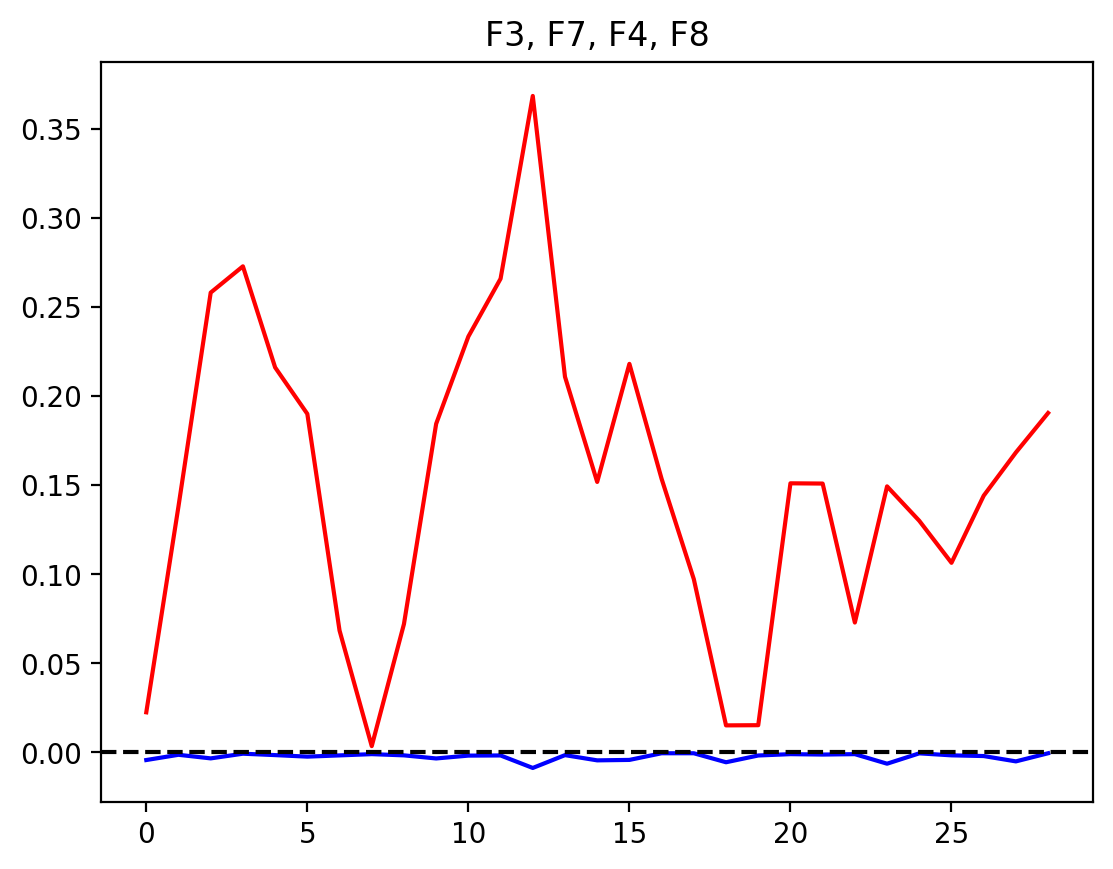

In [127]:
plt.plot(OI4,c='red')
plt.plot(OI4rnd,c='blue')
plt.axhline(ls='--',c='black')
plt.title('F3, F7, F4, F8')

Text(0.5, 1.0, 'F3, F7, F4, F8')

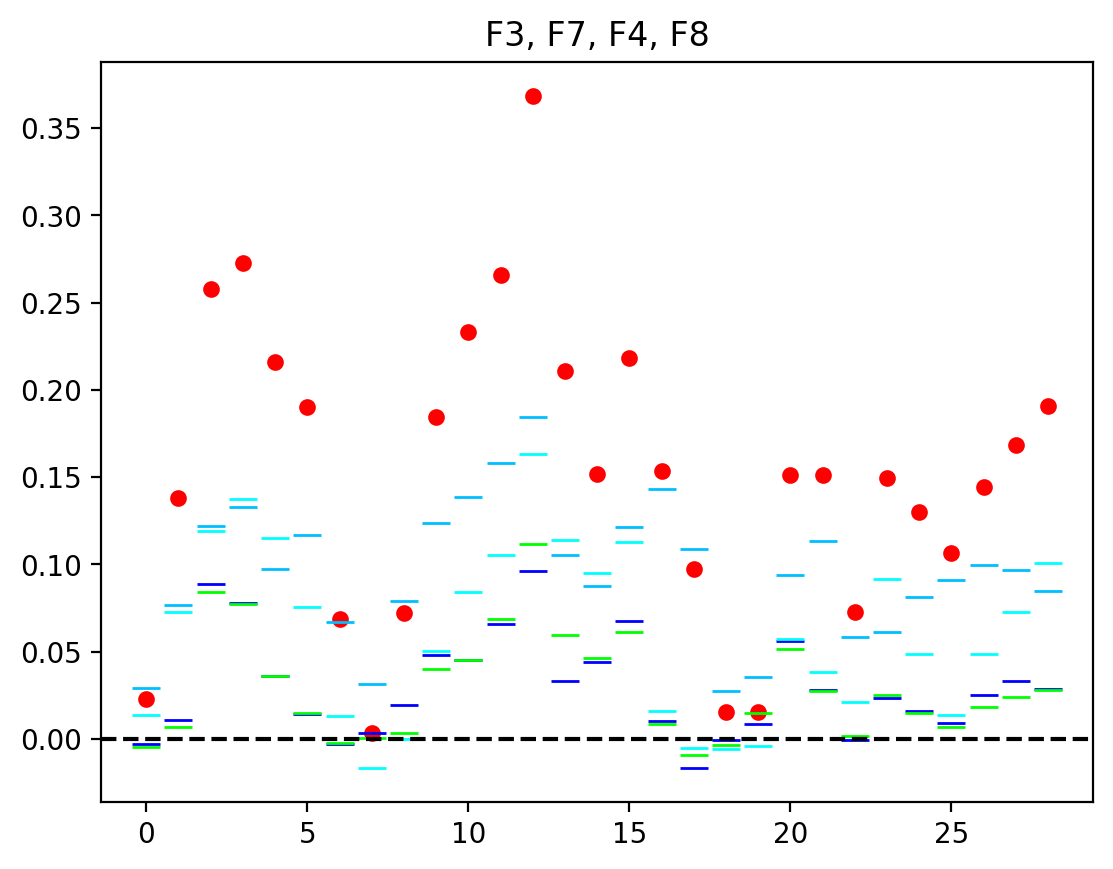

In [128]:
plt.plot(OI4,c='red',marker='.',ms=10,ls='')
plt.plot(OI4ctrl1,c='blue',marker='_',ms=10,ls='')
plt.plot(OI4ctrl2,c='cyan',marker='_',ms=10,ls='')
plt.plot(OI4ctrl3,c='lime',marker='_',ms=10,ls='')
plt.plot(OI4ctrl4,c='deepskyblue',marker='_',ms=10,ls='')
plt.axhline(ls='--',c='black')
plt.title('F3, F7, F4, F8')